<a href="https://colab.research.google.com/github/suafle/Clase2/blob/master/Upper_fractions_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import time
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from scipy import stats
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from astropy.coordinates import SkyCoord
from astropy.table import Table
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import rc
from astropy import units as u
from astropy.io import fits
from sklearn import svm

In [4]:
file1 = '/content/drive/My Drive/PhD_data/5_p_=10-result.fits.gz'
ruwe = '/content/drive/My Drive/PhD_data/5_p_=10ruwe-result.fits.gz'

#data and ruwe
dat = Table.read(file1,format='fits')
dat_ruwe = Table.read(ruwe,format='fits')

df = dat.to_pandas()
df_ruwe = dat_ruwe.to_pandas()
df['ruwe'] = df_ruwe['ruwe']

print('All stars = ',len(df))

All stars =  1714970


In [5]:
#Wiping out data with no bp - rg magnitude calculation (i.e. color)
df = df.dropna(subset=['bp_rp'])

print('All stars with bp-rp colors = ',len(df))
print('Fraction lost = ',(1714970-len(df))/1714970.)

All stars with bp-rp colors =  1698200
Fraction lost =  0.009778596710146532


In [6]:
df['dist'] = 1000./df['parallax']

#calculating absolute magnitude
df['g_abs'] = df['phot_g_mean_mag'] - 5*np.log10(df['dist']/10)

#creating colors
df['w1_w2'] = df['w1mpro'] - df['w2mpro']
df['w2_w3'] = df['w2mpro'] - df['w3mpro']
df['w3_w4'] = df['w3mpro'] - df['w4mpro']
df['g_w3'] = df['phot_g_mean_mag'] - df['w3mpro']
df['g_w4'] = df['phot_g_mean_mag'] - df['w4mpro']

print(len(df))
print(len(np.where(df['g_abs']>15)[0]))

1698200
31801


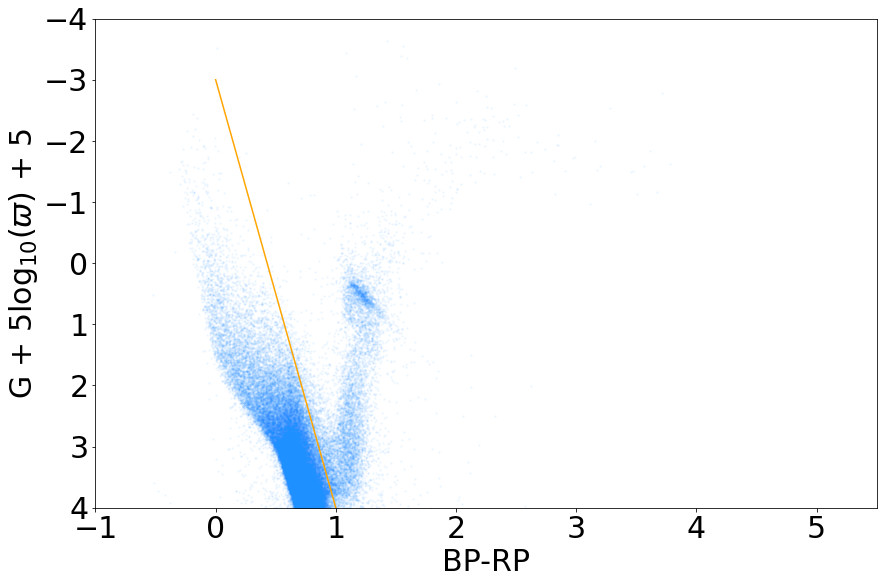

In [7]:
#Checking line to cut
x = np.linspace(0,2,10)
y = 7*x - 3.0

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.plot(x,y,c='orange')
plt.scatter(df['bp_rp'],df['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.xlabel('BP-RP')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(4,-4)
plt.xlim(-1,5.5)
plt.show()
plt.close()

In [8]:
#Cleaning RGS

#Massive star
df_mas = df[(df['g_abs'] < 4)]
#Not massive
df_sma = df[(df['g_abs'] >= 4)]

#Filtering for massive stars
df_mas = df_mas[(df_mas['g_abs'] > 7*df_mas['bp_rp'] - 3.0)]

#Reseting index
df_mas = df_mas.reset_index(drop=True)
df_sma = df_sma.reset_index(drop=True)

frames = [df_mas,df_sma]
df_new = pd.concat(frames)

In [9]:
#W4
#T =  30
m_30 =  {0: 1.016119791372077, 1: 1.0166871062892417, 2: 1.0173833447863188, 3: 1.0225248994718994, 4: 1.0281602687210627, 5: 1.0597458584391408, 6: 1.0866111954977822, 7: 1.2272523739657988, 8: 1.2638074860510247, 9: 1.3067030215696553, 10: 1.3618761926363694, 11: 1.4447711559341772, 12: 1.4560800453511067, 13: 1.4682870910007195, 14: 1.4815538698277808, 15: 1.4960889839454417, 16: 1.5121710378744788}
n_30 =  {0: 2.7681011193136187, 1: 2.7633591768448946, 2: 2.757539390112045, 3: 2.714566821558153, 4: 2.6675011788314427, 5: 2.4056132465983593, 6: 2.1869606241228023, 7: 1.1156858884687035, 8: 0.8473012118620903, 9: 0.5284999957466973, 10: 0.10382107714206704, 11: -0.5879557608066802, 12: -0.689366326618471, 13: -0.8012673507584268, 14: -0.9260643672478082, 15: -1.0671008393834247, 16: -1.2292608790098303}
#T =  35
m_35 =  {0: 1.0172848765890028, 1: 1.0220742310241608, 2: 1.0273243948435449, 3: 1.0562864401356828, 4: 1.0797224881610235, 5: 1.1706417309420414, 6: 1.2300313215468377, 7: 1.447904977708686, 8: 1.4858584629292162, 9: 1.5225597446429007, 10: 1.5592758747297872, 11: 1.5973932443262113, 12: 1.6013513415257907, 13: 1.6053455576367834, 14: 1.609379404087353, 15: 1.6134559465251381, 16: 1.6175796769529263}
n_35 =  {0: 2.757912712325717, 1: 2.7160858571234354, 2: 2.6699943462398963, 3: 2.412021001810462, 4: 2.199335474749758, 5: 1.346250892248165, 6: 0.7674248936961858, 7: -1.5052704423494878, 8: -1.9378615763121039, 9: -2.3790982808919154, 10: -2.8603793856731072, 11: -3.456448046761728, 12: -3.5303116876370533, 13: -3.608959459649123, 14: -3.693608360184516, 15: -3.786019163804903, 16: -3.88890873575712}
#T =  40
m_40 =  {0: 1.0221747748291359, 1: 1.0404429911577437, 2: 1.056686677224745, 3: 1.1242842856375268, 4: 1.1689947064719983, 5: 1.3132420269221583, 6: 1.3902514114655595, 7: 1.572680778938493, 8: 1.5912072810837308, 9: 1.606287273241709, 10: 1.6189029854792263, 11: 1.6296913073596617, 12: 1.6306881455867057, 13: 1.631671491170012, 14: 1.6326421356376, 15: 1.6336000581783525, 16: 1.6345462528912609}
n_40 =  {0: 2.7149836661058933, 1: 2.552760962257116, 2: 2.406200486139358, 3: 1.7754899580250334, 4: 1.3403010653991243, 5: -0.17157166462039672, 6: -1.0625607034017046, 7: -3.6580799665614134, 8: -4.020583305412647, 9: -4.362098097864554, 10: -4.713062991267381, 11: -5.140854157280457, 12: -5.195163620445047, 13: -5.253637730787684, 14: -5.3174444267207965, 15: -5.388283245345516, 16: -5.468794551423153}
#T =  45
m_45 =  {0: 1.0340392901118056, 1: 1.0740188720335815, 2: 1.103812294765707, 3: 1.2096707012884123, 4: 1.2717573570116263, 5: 1.4391450994387867, 6: 1.507512477311373, 7: 1.6157412080637776, 8: 1.623029691188886, 9: 1.6285165151736192, 10: 1.6328064439758292, 11: 1.6362604289112477, 12: 1.6365696494705606, 13: 1.6368728628064344, 14: 1.6371706445951801, 15: 1.6374627435182767, 16: 1.637749911700449}
n_45 =  {0: 2.6098285123517, 1: 2.2469688142910424, 2: 1.9686469073751396, 3: 0.9249525217855186, 4: 0.2688257283724109, 5: -1.7327066500529624, 6: -2.7213866514160836, 7: -5.046109272896095, 8: -5.340071471764869, 9: -5.619322742966274, 10: -5.913076958538673, 11: -6.287221625627748, 12: -6.3362810601536514, 13: -6.389511879473656, 14: -6.448076668370719, 15: -6.513667571480298, 16: -6.588916071543453}
#T =  50
m_50 =  {0: 1.0532366791125822, 1: 1.1170679214185975, 2: 1.1596112780360925, 3: 1.2961303338710315, 4: 1.3673577860318131, 5: 1.5235461552159233, 6: 1.5716240032442792, 7: 1.6294920134147453, 8: 1.6326028142213815, 9: 1.6348790307681773, 10: 1.6366192281693723, 11: 1.6379942691516378, 12: 1.6381162442785386, 13: 1.6382355217915539, 14: 1.6383525769273817, 15: 1.6384670586838315, 16: 1.638579622191577}
n_50 =  {0: 2.437076504289963, 1: 1.84226737116072, 2: 1.428627289168834, 3: -0.00336187774615993, 4: -0.830960035129145, 5: -3.0222392407778034, 6: -3.9525454337294326, 7: -5.995169679371112, 8: -6.259743796501572, 9: -6.515503046173589, 10: -6.789829824632397, 11: -7.147336884038586, 12: -7.194842357583722, 13: -7.246533783121237, 14: -7.303572192004506, 15: -7.3676474134782035, 16: -7.441388641153282}
#T =  55
m_55 =  {0: 1.0773219425038212, 1: 1.1633915818744645, 2: 1.2166871109024995, 3: 1.3725816947627367, 4: 1.4438112293532452, 5: 1.571687685321776, 6: 1.60267512818852, 7: 1.6344404844256863, 8: 1.635970624740692, 9: 1.6370782310124214, 10: 1.6379181735549648, 11: 1.6385772784049581, 12: 1.6386355848111427, 13: 1.6386924546696522, 14: 1.638748324103391, 15: 1.6388028040353044, 16: 1.6388565133154813}
n_55 =  {0: 2.2161983694530347, 1: 1.3908899458248813, 2: 0.8501680690762147, 3: -0.8975009170047702, 4: -1.8192419198657963, 5: -3.9833752773043787, 6: -4.827229152383727, 7: -6.701120877896451, 8: -6.953679410006875, 9: -7.200259930855189, 10: -7.467262854735297, 11: -7.818682730432467, 12: -7.8656284823272005, 13: -7.91676692936856, 14: -7.973258622690799, 15: -8.036792471978341, 16: -8.109997006223862}
#T =  60
m_60 =  {0: 1.1034790815717066, 1: 1.208827259778627, 2: 1.2703559196315153, 3: 1.4339904760386282, 4: 1.4990710419524134, 5: 1.5977342112784092, 6: 1.617746327318544, 7: 1.6365066866686384, 8: 1.6373637176234082, 9: 1.6379813263612721, 10: 1.6384482759859698, 11: 1.6388136668962807, 12: 1.638845987229277, 13: 1.6388774084829791, 14: 1.6389083499912585, 15: 1.6389384064121113, 16: 1.6389681811633885}
n_60 =  {0: 1.97131573179878, 1: 0.9312312681697269, 2: 0.2792577133540725, 3: -1.6874590668095837, 4: -2.636343406786689, 5: -4.690285056116033, 6: -5.468521976973045, 7: -7.251572672454421, 8: -7.498738873590616, 9: -7.741275309739593, 10: -8.005098043153875, 11: -8.353907735951376, 12: -8.400615140766877, 13: -8.451518378300717, 14: -8.507777855355801, 15: -8.571082027837017, 16: -8.644059237068793}
#T =  65
m_65 =  {0: 1.129653613110598, 1: 1.2509376855028747, 2: 1.318057673392113, 3: 1.480363301103668, 4: 1.536917173654914, 5: 1.6120332363118912, 6: 1.6254897316236645, 7: 1.6374889373497274, 8: 1.6380229465575322, 9: 1.6384070858119544, 10: 1.6386973084937717, 11: 1.6389241932380234, 12: 1.6389442900168825, 13: 1.6389637457179842, 14: 1.6389829715615705, 15: 1.639001554354841, 16: 1.6390200900717076}
n_65 =  {0: 1.7210737572610855, 1: 0.4888304638247924, 2: -0.25383070853744266, 3: -2.3489185948448585, 4: -3.28537078504926, 5: -5.222975985586598, 6: -5.958555252984222, 7: -7.691910164760381, 8: -7.936386586913578, 9: -8.17692354375094, 10: -8.439185262047229, 11: -8.786722026152015, 12: -8.833313628987211, 13: -8.884102643770188, 14: -8.940249448708228, 15: -9.003442234506807, 16: -9.076309313762588}
#T =  70
m_70 =  {0: 1.1545034984841425, 1: 1.28845295193766, 2: 1.3587685641171272, 3: 1.5140929743999205, 4: 1.5621905547834307, 5: 1.620074816483874, 6: 1.629613123899293, 7: 1.6378853932750852, 8: 1.6382498436632342, 9: 1.6385122216536396, 10: 1.6387108579307246, 11: 1.6388664401554738, 12: 1.6388802692355466, 13: 1.6388935956171424, 14: 1.6389068229756678, 15: 1.6389195373222958, 16: 1.6389323278939705}
n_70 =  {0: 1.4791523561267763, 1: 0.08045369077710042, 2: -0.7313177229034338, 3: -2.885784391229477, 4: -3.793159563908781, 5: -5.634410471244792, 6: -6.3430883982661355, 7: -8.047921626446012, 8: -8.290921667046874, 9: -8.530361200499776, 10: -8.791760925518155, 11: -9.138577637082054, 12: -9.185101420122022, 13: -9.235822744791337, 14: -9.291901752574832, 15: -9.35502620816569, 16: -9.427823946315717}
#T =  75 
m_75 =  {0: 1.1775254995848436, 1: 1.3210823954905082, 2: 1.3927146687908947, 3: 1.5385689580661353, 4: 1.5793938042798668, 5: 1.6250385655875417, 6: 1.632135109286844, 7: 1.6381851031539094, 8: 1.6384503260970613, 9: 1.638641349433297, 10: 1.6387861488404587, 11: 1.638899609868791, 12: 1.6389097229950416, 13: 1.638919411858178, 14: 1.6389290776090133, 15: 1.6389383038164282, 16: 1.6389476774012375}
n_75 =  {0: 1.2501348047200516, 1: -0.2882518708732363, 2: -1.1497696640186565, 3: -3.3200700626834645, 4: -4.195367628683059, 5: -5.9630786014163615, 6: -6.654364372624104, 7: -8.341762699685582, 8: -8.583891456147686, 9: -8.822687802645088, 10: -9.083587920496576, 11: -9.42999863941777, 12: -9.476485550863815, 13: -9.52717049477464, 14: -9.583213639617666, 15: -9.646302625636343, 16: -9.719065331841652}
#T =  80
m_80 =  {0: 1.1983130844789596, 1: 1.3489118091106123, 2: 1.4205330670633636, 3: 1.5562937868608644, 4: 1.5912164021771982, 5: 1.6281911253514385, 6: 1.6337118327582834, 7: 1.638369507936152, 8: 1.6385735129372583, 9: 1.6387205684243098, 10: 1.638832229398068, 11: 1.6389197928124761, 12: 1.6389276229671519, 13: 1.6389350773851001, 14: 1.6389425556642376, 15: 1.63894963987185, 16: 1.6389569155053085}
n_80 =  {0: 1.0395578616869228, 1: -0.6136287042021291, 2: -1.5091959146552372, 3: -3.6701166702480896, 4: -4.515868351691522, 5: -6.228930376275564, 6: -6.9086750285323975, 7: -8.584905230091477, 8: -8.826486294772678, 9: -9.064879069947414, 10: -9.325466242997578, 11: -9.671623115692787, 12: -9.718087003744968, 13: -9.768749228125685, 14: -9.824769988402286, 15: -9.887836831545936, 16: -9.960577685042804}
#T =  85
m_85 =  {0: 1.2167894208217132, 1: 1.372361803645909, 2: 1.4431286926643214, 3: 1.569253906011697, 4: 1.5995172169911327, 5: 1.6302836653623705, 6: 1.634747471761769, 7: 1.6384893032609698, 8: 1.6386534427500665, 9: 1.6387718915994205, 10: 1.6388620098624291, 11: 1.6389327531454274, 12: 1.6389391014209334, 13: 1.638945105623483, 14: 1.6389511643400712, 15: 1.6389568586604575, 16: 1.6389627731555774}
n_85 =  {0: 0.8492464729179916, 1: -0.8967332777610661, 2: -1.814507144598334, 3: -3.9534618999091933, 4: -4.774041063089949, 5: -6.446611955527573, 6: -7.118447085575727, 7: -8.787199366387894, 8: -9.028418321799043, 9: -9.26654464165628, 10: -9.526925480925145, 11: -9.87291522703463, 12: -9.919363972831942, 13: -9.97001125162849, 14: -10.026017293494654, 15: -10.089069572903929, 16: -10.161796063897935}
#T =  90
m_90 =  {0: 1.2330172332068874, 1: 1.3919681217356443, 2: 1.461408696255726, 3: 1.578855025989339, 4: 1.6054768087220663, 5: 1.6317261192961876, 6: 1.635456206356402, 7: 1.6385706236024318, 8: 1.6387076408345727, 9: 1.6388066411013074, 10: 1.6388821234791617, 11: 1.6389414480000464, 12: 1.638946790739504, 13: 1.6389518109781551, 14: 1.63895690661473, 15: 1.638961658073492, 16: 1.638966649294548}
n_90 =  {0: 0.6795438066442829, 1: -1.1405835435718954, 2: -2.0720871745788654, 3: -4.184122876102922, 4: -4.984000358858104, 5: -6.62634794350484, 6: -7.29259704984863, 7: -8.956151922121856, 8: -9.197121451624412, 9: -9.435064438975306, 10: -9.695303477385762, 11: -10.041178501944682, 12: -10.08761686226922, 13: -10.138253887657635, 14: -10.194249836239475, 15: -10.257292124784012, 16: -10.330008769678766}
#T =  95
m_95 =  {0: 1.2471368233320301, 1: 1.4082802266244967, 2: 1.4761825607173638, 3: 1.5860679011863914, 4: 1.6098464748415822, 5: 1.6327525048724394, 6: 1.6359578978452989, 7: 1.6386278257852773, 8: 1.6387457240221814, 9: 1.638831022713116, 10: 1.6388962001890561, 11: 1.6389474900193552, 12: 1.6389521254943373, 13: 1.6389564536900372, 14: 1.63896087201944, 15: 1.6389649604372054, 16: 1.638969302438262}
n_95 =  {0: 0.5298615658304772, 1: -1.3490759884759818, 2: -2.2884834687931677, 3: -4.372919383841076, 4: -5.15603703122334, 5: -6.775569892992054, 6: -7.4377685568257546, 7: -9.097597463491216, 8: -9.338389372717728, 9: -9.576201929088326, 10: -9.836340184303337, 11: -10.182133749482134, 12: -10.228564740429016, 13: -10.279194487860364, 14: -10.335183274896426, 15: -10.398218471644162, 16: -10.470928131943827}
#T =  100
m_100 =  {0: 1.2593259881553596, 1: 1.4218081342215152, 2: 1.4881298587475236, 3: 1.5915593635566772, 4: 1.6131108567503425, 5: 1.6335022243113322, 6: 1.6363229588687194, 7: 1.638669239305098, 8: 1.6387732685231535, 9: 1.6388486330589855, 10: 1.6389063429139523, 11: 1.6389518133778154, 12: 1.638955936756619, 13: 1.6389597639056774, 14: 1.638963691885283, 15: 1.6389673003089988, 16: 1.6389711723484799}
n_100 =  {0: 0.39906395983360554, 1: -1.5263141893513834, 2: -2.469759923472007, 3: -4.528122630763682, 4: -5.297754309742625, 5: -6.899857851279793, 6: -7.55905329071328, 7: -9.21614255700774, 8: -9.45680453757127, 9: -9.694521761565506, 10: -9.954586417342524, 11: -10.300320541645915, 12: -10.346746158151692, 13: -10.397370596069317, 14: -10.453354160369695, 15: -10.516384183045869, 16: -10.58908875053474}
#T =  125
m_125 =  {0: 1.2977361246128811, 1: 1.4611439788091032, 2: 1.5212629530457031, 3: 1.605287832308213, 4: 1.621032579502305, 5: 1.6352616464795635, 6: 1.6371748849953194, 7: 1.6387650322143272, 8: 1.6388368470906889, 9: 1.6388891586430687, 10: 1.6389295555804582, 11: 1.6389615473253336, 12: 1.6389644852481067, 13: 1.6389671526327898, 14: 1.638969945718573, 15: 1.6389724433250077, 16: 1.638975227871045}
n_125 =  {0: -0.02337873198550818, 1: -2.0685016790367667, 2: -3.010059304070155, 3: -4.978900112299809, 4: -5.711883237490338, 5: -7.270172464694209, 6: -7.922145394326494, 7: -9.572726106911546, 8: -9.813081973076818, 9: -10.050574928299218, 10: -10.310466714402104, 11: -10.656061411129702, 12: -10.702474432874302, 13: -10.753086418496743, 14: -10.80905774268883, 15: -10.872075627163639, 16: -10.944768261692895}
#T =  150
m_150 =  {0: 1.3119181958479063, 1: 1.4744358236716997, 2: 1.5319074035985076, 3: 1.6092571703737664, 4: 1.6232585301841707, 5: 1.6357408595375753, 6: 1.637405704209678, 7: 1.6387907205290104, 8: 1.6388538479938553, 9: 1.6388999497701353, 10: 1.638935688376652, 11: 1.6389640575108029, 12: 1.6389666770265074, 13: 1.6389690329394366, 14: 1.6389715212667373, 15: 1.6389737206131878, 16: 1.6389762131942238}
n_150 =  {0: -0.18362323549839948, 1: -2.2626891065361203, 2: -3.1988032860352833, 3: -5.133588683209848, 4: -5.855135016039844, 5: -7.400677612629873, 6: -8.050632617379842, 7: -9.699415301289015, 8: -9.93968734327904, 9: -10.177118996038923, 10: -10.436963617452818, 11: -10.782520329633185, 12: -10.82892992371451, 13: -10.87953851661637, 14: -10.935506508965718, 15: -10.998521084563977, 16: -11.071210471430382}
#T =  175
m_175 =  {0: 1.313331233779408, 1: 1.4757246778239326, 2: 1.5329245057240453, 3: 1.6096257600560904, 4: 1.6234637469538096, 5: 1.6357847053919343, 6: 1.6374267953995425, 7: 1.638793059760627, 8: 1.638855394331425, 9: 1.6389009295392445, 10: 1.6389362432718628, 11: 1.6389642821078063, 12: 1.6389668725976105, 13: 1.638969200117806, 14: 1.6389716606652442, 15: 1.638973832825091, 16: 1.638976298794168}
n_175 =  {0: -0.19972460848715384, 1: -2.281868950824959, 2: -3.2173212003905682, 3: -5.14871867595274, 4: -5.869182493543471, 5: -7.413539186568907, 6: -8.06330827969186, 7: -9.711925762678389, 8: -9.952190121445721, 9: -10.18961615822154, 10: -10.449456461131735, 11: -10.795009696604534, 12: -10.84141897702325, 13: -10.892027259330712, 14: -10.947994946740806, 15: -11.011009219338455, 16: -11.083698308952018}
#T =  200
m_200 =  {0: 1.3079304173880082, 1: 1.4707640128951194, 2: 1.528995164817109, 3: 1.6081915741787067, 4: 1.6226638269883467, 5: 1.6356134790788137, 6: 1.6373444031975894, 7: 1.63878391181582, 8: 1.6388493445582668, 9: 1.6388970937732072, 10: 1.6389340679447912, 11: 1.638963397718385, 12: 1.6389661016583368, 13: 1.6389685401548588, 14: 1.6389711092840407, 15: 1.6389733877076804, 16: 1.6389759576952496}
n_200 =  {0: -0.13831722102612265, 1: -2.20839886890694, 2: -3.1462679469217663, 3: -5.09062482794663, 4: -5.815280872560491, 5: -7.364249656331604, 6: -8.014743509182056, 7: -9.664005431816285, 8: -9.904299779189515, 9: -10.141747738475676, 10: -10.401604901030101, 11: -10.747171710447999, 12: -10.793582215498802, 13: -10.84419171031113, 14: -10.900160588210307, 15: -10.96317604353609, 16: -11.035866293547711}
#T =  225
m_225 =  {0: 1.2988843136580555, 1: 1.4622443733934742, 2: 1.5221548773878069, 3: 1.6056283656838168, 4: 1.6212246895834674, 5: 1.6353032665503398, 6: 1.6371949533369332, 7: 1.638767271022586, 8: 1.6388383298250937, 9: 1.6388901007887946, 10: 1.6389300920897862, 11: 1.638961768303473, 12: 1.6389646784887404, 13: 1.6389673187393778, 14: 1.6389700852752649, 15: 1.6389725568972582, 16: 1.6389753160066374}
n_225 =  {0: -0.03626215829536287, 1: -2.0843393796543537, 2: -3.025541170192778, 3: -4.991626642333617, 4: -5.723644163200854, 5: -7.280841479270489, 6: -7.932640124378438, 7: -9.583065188054338, 8: -9.82341378353113, 9: -10.06090141927276, 10: -10.320789110875118, 11: -10.666380508947373, 12: -10.712793232955425, 13: -10.763404923964009, 14: -10.819375958761519, 15: -10.88239355594504, 16: -10.955085908381557}
#T =  250
m_250 =  {0: 1.2879588321291677, 1: 1.4515983473737606, 2: 1.5134452163089993, 3: 1.6022396908855991, 4: 1.6193034687324792, 5: 1.634884811481684, 6: 1.6369930001315964, 7: 1.638744698368972, 8: 1.6388233719771461, 9: 1.638880588629784, 10: 1.6389246670111286, 11: 1.6389595230859977, 12: 1.6389627128369217, 13: 1.6389656265765515, 14: 1.638968660719127, 15: 1.638971394253532, 16: 1.6389744097592558}
n_250 =  {0: 0.08570645926446067, 1: -1.9327869020072266, 2: -2.876724651823618, 3: -4.868945137481066, 4: -5.610445012909487, 5: -7.178495703610248, 6: -7.832038740515184, 7: -9.484024689347956, 8: -9.724446312026117, 9: -9.96198739454092, 10: -10.221916239200631, 11: -10.567540800177227, 12: -10.613956518018247, 13: -10.664571170814158, 14: -10.720545115426512, 15: -10.783565600469874, 16: -10.856260789369447}
#T =  275
m_275 =  {0: 1.2761765754016325, 1: 1.4396740945336237, 2: 1.5034778783834404, 3: 1.5981850912952913, 4: 1.6169770090269384, 5: 1.6343714586413212, 6: 1.6367447056390285, 7: 1.6387168292137748, 8: 1.6388048830150428, 9: 1.6388688109772855, 10: 1.6389179286296789, 11: 1.6389567071969984, 12: 1.6389602418935956, 13: 1.6389634930964685, 14: 1.6389668574590737, 15: 1.6389699142015992, 16: 1.638973246122787}
n_275 =  {0: 0.21572352395364663, 1: -1.767179728790403, 2: -2.7123386138561596, 3: -4.732353312114575, 4: -5.4848390152089035, 5: -7.065842961399895, 6: -7.721503498607663, 7: -9.375393128608353, 8: -9.6159041406557, 9: -9.853510693045356, 10: -10.113489987014779, 11: -10.459155226951692, 12: -10.505574618720985, 13: -10.556192904457808, 14: -10.612170419601906, 15: -10.675194446165499, 16: -10.74789311585286}
#T =  300
m_300 =  {0: 1.2641438276248151, 1: 1.4270147222874927, 2: 1.4926535479062824, 3: 1.5935614946485663, 4: 1.614287501567036, 5: 1.633768910779967, 6: 1.6364525276102369, 7: 1.6386838907327286, 8: 1.6387830064886755, 9: 1.6388548527587756, 10: 1.6389099187760108, 11: 1.6389533296595735, 12: 1.6389572718344798, 13: 1.6389609216958352, 14: 1.6389646761788703, 15: 1.638968114776215, 16: 1.6389718205449155}
n_300 =  {0: 0.34694860904754554, 1: -1.5956703330142832, 2: -2.5400464603418436, 3: -4.587670645509635, 4: -5.352224035151799, 5: -6.947960128632573, 6: -7.6060773852347765, 7: -9.262187859892808, 8: -9.502803566150433, 9: -9.740486855359768, 10: -10.00052532713615, 11: -10.346238314975052, 12: -10.39266202105512, 13: -10.443284571162033, 14: -10.499266278952746, 15: -10.562294461833558, 16: -10.634997219166404}
#T =  325
m_325 =  {0: 1.2761765754016325, 1: 1.4396740945336237, 2: 1.5034778783834404, 3: 1.5981850912952913, 4: 1.6169770090269384, 5: 1.6343714586413212, 6: 1.6367447056390285, 7: 1.6387168292137748, 8: 1.6388048830150428, 9: 1.6388688109772855, 10: 1.6389179286296789, 11: 1.6389567071969984, 12: 1.6389602418935956, 13: 1.6389634930964685, 14: 1.6389668574590737, 15: 1.6389699142015992, 16: 1.638973246122787}
n_325 =  {0: 0.21572352395364663, 1: -1.767179728790403, 2: -2.7123386138561596, 3: -4.732353312114575, 4: -5.4848390152089035, 5: -7.065842961399895, 6: -7.721503498607663, 7: -9.375393128608353, 8: -9.6159041406557, 9: -9.853510693045356, 10: -10.113489987014779, 11: -10.459155226951692, 12: -10.505574618720985, 13: -10.556192904457808, 14: -10.612170419601906, 15: -10.675194446165499, 16: -10.74789311585286}
#T =  350
m_350 =  {0: 1.2406273897343094, 1: 1.4008459599776757, 2: 1.4694988403539706, 3: 1.5828637257180538, 4: 1.6079167871282085, 5: 1.632302477618275, 6: 1.6357381973998297, 7: 1.6386028158569486, 8: 1.6387290784289343, 9: 1.6388203704873794, 10: 1.6388900548647427, 11: 1.6389448581592476, 12: 1.6389498028855738, 13: 1.6389544336734367, 14: 1.6389591481490609, 15: 1.6389635264737497, 16: 1.6389681523392627}
n_350 =  {0: 0.599107807485937, 1: -1.2533820396131923, 2: -2.189592412846563, 3: -4.28715480603882, 4: -5.0778488698565, 5: -6.707527773801988, 6: -7.3715106730565445, 7: -9.032976488368936, 8: -9.273846304755878, 9: -9.511716056477713, 10: -9.77189849495986, 11: -10.11772776368164, 12: -10.164161984131608, 13: -10.214794921319506, 14: -10.270786846802375, 15: -10.333825151850153, 16: -10.40653787301204}
#T =  375
m_375 =  {0: 1.2294798105726767, 1: 1.38777276148563, 2: 1.4575447494893414, 3: 1.5768891143549355, 4: 1.6042697864073876, 5: 1.6314379640327654, 6: 1.6353149651642045, 7: 1.6385544638909721, 8: 1.6386968758150133, 9: 1.6387997434862436, 10: 1.6388781355611886, 11: 1.6389397297963306, 12: 1.6389452724148916, 13: 1.6389504882574015, 14: 1.6389557753669632, 15: 1.6389607143127443, 16: 1.6389658891827594}
n_375 =  {0: 0.7167453232439329, 1: -1.087812722324857, 2: -2.016760658538967, 3: -4.135157992721466, 4: -4.939421290993094, 5: -6.5879713744625485, 6: -7.255345899284767, 7: -8.919942385728524, 8: -9.160961751120464, 9: -9.39894135396986, 10: -9.659208701516842, 11: -10.005106621908057, 12: -10.05154705477047, 13: -10.102186126800646, 14: -10.158184090023056, 15: -10.221228373522552, 16: -10.293946984631551}
#T =  400
m_400 =  {0: 1.2188441654260598, 1: 1.374895361591012, 2: 1.445522553602064, 3: 1.5705551135978826, 4: 1.6003344141990732, 5: 1.6304843938801772, 6: 1.6348463521920655, 7: 1.6385006835879694, 8: 1.6386610315247545, 9: 1.6387767610798631, 10: 1.6388648329464421, 11: 1.638933981088709, 12: 1.6389401892148974, 13: 1.638946056424812, 14: 1.6389519812702014, 15: 1.6389575448495164, 16: 1.6389633318283614}
n_400 =  {0: 0.8278931648863497, 1: -0.927858617498972, 2: -1.8476597749107944, 3: -3.983550124766192, 4: -4.80142828302817, 5: -6.4699135157261, 6: -7.140978240853938, 7: -8.809009632789897, 8: -9.050193882688305, 9: -9.288294684903034, 10: -9.548655783734766, 11: -9.894629571719923, 12: -9.941076876012177, 13: -9.991722733425531, 14: -10.047727378204316, 15: -10.11077827837003, 16: -10.18350341531655}
#T =  425
m_425 =  {0: 1.2087479554842735, 1: 1.3623036539811573, 2: 1.4335334448884085, 3: 1.5639018849542694, 4: 1.5961247944657413, 5: 1.629440318655704, 6: 1.6343311427168252, 7: 1.6384412815425802, 8: 1.6386214157105412, 9: 1.6387513408751404, 10: 1.6388501030050124, 11: 1.638927605631686, 12: 1.6389345515073317, 13: 1.6389411415060366, 14: 1.6389477750081667, 15: 1.6389540341421451, 16: 1.6389605050139455}
n_425 =  {0: 0.9324484223630084, 1: -0.774228947955393, 2: -1.6832309661175022, 3: -3.8330586017581045, 4: -4.664410438286691, 5: -6.353748951733714, 6: -7.02879789175959, 7: -8.700571712775321, 8: -8.941936544132954, 9: -9.180170181282358, 10: -9.440634125361212, 11: -9.78669128182449, 12: -9.833146156203282, 13: -9.883799494648805, 14: -9.939811517970897, 15: -10.002869738328338, 16: -10.075602122160026}
#T =  450
m_450 =  {0: 1.1991955723781071, 1: 1.3500592752454044, 2: 1.421656952825561, 3: 1.5569680490853959, 4: 1.5916554623335213, 5: 1.6283042746247323, 6: 1.6337680585690266, 7: 1.6383760565338494, 8: 1.6385778986791544, 9: 1.6387234095812537, 10: 1.6388339244671142, 11: 1.6389206549453124, 12: 1.6389284229842729, 13: 1.6389358216850896, 14: 1.638943252593853, 15: 1.638950301064511, 16: 1.638957558554127}
n_450 =  {0: 1.03053642893635, 1: -0.6272819512825156, 2: -1.5240773633110571, 3: -3.684205911463427, 4: -4.52872402840829, 5: -6.239689318328792, 6: -6.91901169785638, 7: -8.594839230958005, 8: -8.836400773283577, 9: -9.074779250648213, 10: -9.335355515934236, 11: -9.681504178610238, 12: -9.727967438712657, 13: -9.77862909581136, 14: -9.834649372719733, 15: -9.897715849401157, 16: -9.970456521960608}
#T =  475
m_475 =  {0: 1.1901770461577865, 1: 1.3382027587324328, 2: 1.4099550454831504, 3: 1.5497908751743532, 4: 1.58694157799819, 5: 1.6270748916689546, 6: 1.6331558123766785, 7: 1.6383048208657474, 8: 1.638530378755866, 9: 1.6386929434710251, 10: 1.6388163660268442, 11: 1.6389133879993998, 12: 1.63892210071879, 13: 1.6389304409094207, 14: 1.6389388174026285, 15: 1.638946827278111, 16: 1.6389550825986785}
n_475 =  {0: 1.122413379230319, 1: -0.4871378983323943, 2: -1.3705609194899167, 3: -3.5373760971281563, 4: -4.394607041005595, 5: -6.127828500573931, 6: -6.811708095991715, 7: -8.491904577246574, 8: -8.733679521491423, 9: -8.972215412495807, 10: -9.232914242151042, 11: -9.579164354691635, 12: -9.62563719717911, 13: -9.676308484477426, 14: -9.732338497627904, 15: -9.795414976447477, 16: -9.868166115383145}
#T =  500
m_500 =  {0: 1.181673746778319, 1: 1.3267588235601886, 2: 1.3984753190279962, 3: 1.5424062321111711, 4: 1.5819989555464506, 5: 1.625750965212602, 6: 1.632493147373382, 7: 1.6382274531836452, 8: 1.6384788572885616, 9: 1.6386600812323602, 10: 1.6387977756151824, 11: 1.6389066906273828, 12: 1.6389165857595351, 13: 1.638926143467578, 14: 1.638935797019785, 15: 1.6389451837810107, 16: 1.6389549877684464}
n_500 =  {0: 1.2084053024946189, 1: -0.3537563208618224, 2: -1.222869510316651, 3: -3.392856768196693, 4: -4.26222100566033, 5: -6.018184825843016, 6: -6.706899075436401, 7: -8.391784010015245, 8: -8.633789937514367, 9: -8.87249693154513, 10: -9.13333044618323, 11: -9.479697196034534, 12: -9.52618197839934, 13: -9.57686566230681, 14: -9.63290877204969, 15: -9.695999515512145, 16: -9.768766846133113}
#T =  525
m_525 =  {0: 1.1736621127637292, 1: 1.3157403574499875, 2: 1.3872535768748973, 3: 1.5348484503140858, 4: 1.5768439988113732, 5: 1.6243315122314848, 6: 1.6317788731148803, 7: 1.6381440036215564, 8: 1.638423597897576, 9: 1.6386253747244597, 10: 1.6387792154243637, 11: 1.6389030649850165, 12: 1.6389146958651484, 13: 1.6389261408279738, 14: 1.6389379082182594, 15: 1.6389497600741638, 16: 1.6389626041710126}
n_525 =  {0: 1.288869925310691, 1: -0.22698959968086307, 2: -1.0810647161568663, 3: -3.2508662154834207, 4: -4.131677835649081, 5: -5.910728782414616, 6: -6.604547755033548, 7: -8.29444579486337, 8: -8.536701981674863, 9: -8.775596260757776, 10: -9.036581292052583, 11: -9.383093954029771, 12: -9.42959620433336, 13: -9.480299034966675, 14: -9.53636375450947, 15: -9.599479944714764, 16: -9.672278962252525}
#T =  550
m_550 =  {0: 1.1661160907080883, 1: 1.305151444385781, 2: 1.3763159492078452, 3: 1.5271501381574684, 4: 1.5714935608131944, 5: 1.6228158119701939, 6: 1.6310119100830354, 7: 1.6380549421781618, 8: 1.6383654935076224, 9: 1.6385903536039021, 10: 1.638763421401281, 11: 1.6389087727178144, 12: 1.6389234715948144, 13: 1.6389384463369363, 14: 1.6389544140701118, 15: 1.6389714843616077, 16: 1.638991189665217}
n_550 =  {0: 1.3641730357910258, 1: -0.10662051759184887, 2: -0.9451165258179263, 3: -3.111571031326115, 4: -4.003056906426274, 5: -5.805401344738407, 6: -6.50458676562253, 7: -8.199830314145421, 8: -8.44235958335081, 9: -8.68146298615753, 10: -8.942627584270769, 11: -9.289349819963757, 12: -9.33588284903475, 13: -9.386621363362206, 14: -9.442728874023013, 15: -9.505898714720397, 16: -9.578768958969116}
#T =  575
m_575 =  {0: 1.1590087176205697, 1: 1.2949896841130564, 2: 1.3656806665760557, 3: 1.5193420296548543, 4: 1.5659647930503864, 5: 1.6212034526539985, 6: 1.6301913522933196, 7: 1.6379616081035595, 8: 1.6383067423005204, 9: 1.6385585796159594, 10: 1.6387566146346224, 11: 1.6389379159461899, 12: 1.6389587611515752, 13: 1.6389810896228334, 14: 1.6390061473388116, 15: 1.6390349248266756, 16: 1.639070538663475}
n_575 =  {0: 1.4346741630922601, 1: 0.007611262283472671, 2: -0.8149290313687229, 3: -2.9750980182627553, 4: -3.8764161514177213, 5: -5.702126374216589, 6: -6.406930784148213, 7: -8.10786575750677, 8: -8.350698298835203, 9: -8.590044859967442, 10: -8.851441762954465, 11: -9.198513661573603, 12: -9.245108113827126, 13: -9.29592065119031, 14: -9.352120360137402, 15: -9.415409984218739, 16: -9.48844457164112}
#T =  600
m_600 =  {0: 1.1523131349843159, 1: 1.2852479701636357, 2: 1.3553595414374635, 3: 1.5114528592851726, 4: 1.5602749802821139, 5: 1.6194943852340178, 6: 1.629316565095407, 7: 1.6378670088402478, 8: 1.6382520450780103, 9: 1.638537507694253, 10: 1.6387716882803893, 11: 1.6390195880226746, 12: 1.639053249216392, 13: 1.6390912416234693, 14: 1.6391360425820094, 15: 1.639190693822314, 16: 1.6392619994952113}
n_600 =  {0: 1.5007182039446534, 1: 0.11599051396259942, 2: -0.690359626917675, 3: -2.8415423191446596, 4: -3.751799110740349, 5: -5.600819057689394, 6: -6.311485313314286, 7: -8.018482594302387, 8: -8.261663214369214, 9: -8.501311571363937, 10: -8.76304375109857, 11: -9.110761470614724, 12: -9.157483395756397, 13: -9.208452821792795, 14: -9.264851766091722, 15: -9.328404716780078, 16: -9.401806041867992}
#T =  625
m_625 =  {0: 1.146003222916953, 1: 1.2759158531755117, 2: 1.345359207222552, 3: 1.5035092767806018, 4: 1.5544413779243702, 5: 1.6176889929593534, 6: 1.6283873330457515, 7: 1.637777113658566, 8: 1.638210543498778, 9: 1.6385414962091314, 10: 1.6388333538833288, 11: 1.6392093677510147, 12: 1.6392693496905393, 13: 1.639339849337994, 14: 1.6394260005747767, 15: 1.6395352676930377, 16: 1.6396823982093551}
n_625 =  {0: 1.5626308593997131, 1: 0.21881330391719303, 2: -0.5712334689003555, 3: -2.7109731554757914, 4: -3.6292393729944257, 5: -5.501391758964042, 6: -6.218153112801625, 7: -7.931629200763607, 8: -8.175230064854999, 9: -8.415285241534503, 10: -8.67755069706079, 11: -9.026505635031757, 12: -9.073487968103992, 13: -9.124781206530363, 14: -9.181595119920878, 15: -9.245700766445292, 16: -9.319876728986879}
#T =  650
m_650 =  {0: 1.1400539782103671, 1: 1.2669805843959183, 2: 1.3356821553376015, 3: 1.495535815658657, 4: 1.5484810756311413, 5: 1.6157881961589107, 6: 1.6274040819011608, 7: 1.6377027988036623, 8: 1.6381987330504282, 9: 1.6385963254106821, 10: 1.6389858422987948, 11: 1.6396063425252754, 12: 1.6397182549310558, 13: 1.639853194601044, 14: 1.640021636027076, 15: 1.6402399210063923, 16: 1.640538709028708}
n_650 =  {0: 1.6207165190392179, 1: 0.3163778244519801, 2: -0.45735442018001005, 3: -2.5834381199859138, 4: -3.5087634530831147, 5: -5.40375831771522, 6: -6.1268393399856285, 7: -7.847290643185641, 8: -8.091432162324844, 9: -8.332081223667947, 10: -8.595246087322849, 11: -8.946550184827522, 12: -8.994043326017906, 13: -9.045974676137089, 14: -9.10360945443252, 15: -9.16881155643105, 16: -9.244527142403205}
#T =  675
m_675 =  {0: 1.1344417247980478, 1: 1.2584279111182817, 2: 1.3263275960465228, 3: 1.487554894422085, 4: 1.542410871327456, 5: 1.6137935847809701, 6: 1.6263681825603595, 7: 1.6376625995851941, 8: 1.6382445738253035, 9: 1.6387455461523284, 10: 1.6393036323279153, 11: 1.6403762294651232, 12: 1.6405856611766103, 13: 1.6408417995370475, 14: 1.6411651495760224, 15: 1.6415886759970686, 16: 1.642172712187161}
n_675 =  {0: 1.6752576519153102, 1: 0.4089780807784187, 2: -0.3485133235014766, 3: -2.458966412620452, 4: -3.390392517065058, 5: -5.307837227780974, 6: -6.037455930914633, 7: -7.765512205213697, 8: -8.010395209125146, 9: -8.251961979232679, 10: -8.516671954873805, 11: -8.87229491024651, 12: -8.920741145319681, 13: -8.973864781522638, 14: -9.03303440864533, 15: -9.100286364504228, 16: -9.178876743243103}
#T =  700
m_700 =  {0: 1.1291442099841937, 1: 1.250242680853794, 2: 1.317292175849906, 3: 1.4795868677959603, 4: 1.5362471847731538, 5: 1.6117076016926881, 6: 1.6252823583733627, 7: 1.6376863590753206, 8: 1.6383929157005277, 9: 1.6390587894030906, 10: 1.639905247567214, 11: 1.6417794576248015, 12: 1.642162595676389, 13: 1.6426344716796224, 14: 1.643233168081301, 15: 1.6440206173226912, 16: 1.6451084810500254}
n_700 =  {0: 1.7265151570307538, 1: 0.4968996490233068, 2: -0.2444942640693157, 3: -2.3375715351811195, 4: -3.274143580159122, 5: -5.213554311537213, 6: -5.949925808016669, 7: -7.68642853034831, 8: -7.932380941182104, 9: -8.175404802928252, 10: -8.4427434078334, 11: -8.805973140906724, 12: -8.856104480061031, 13: -8.911334108147836, 14: -8.973210018003307, 15: -9.044065928006855, 16: -9.127688047028988}
#T =  725
m_725 =  {0: 1.1241406287960367, 1: 1.2424092943076124, 2: 1.308570564789622, 3: 1.47165009586078, 4: 1.530005983312395, 5: 1.6095337667955718, 6: 1.6241512017991706, 7: 1.6378198092165497, 8: 1.638712228073416, 9: 1.6396418717680623, 10: 1.6409693687862303, 11: 1.6441997035280447, 12: 1.6448756414186603, 13: 1.6457101241876757, 14: 1.6467698019075807, 15: 1.6481632356427465, 16: 1.6500836620491737}
n_725 =  {0: 1.7747292523400917, 1: 0.5804169369366924, 2: -0.1450792385764804, 3: -2.2192534360974707, 4: -3.1600301721520108, 5: -5.120844975197096, 6: -5.864187113737646, 7: -7.610298598506058, 8: -7.857839223327133, 9: -8.103181213611451, 10: -8.374876752882045, 11: -8.75087312056879, 12: -8.803818921478417, 13: -8.862554193691881, 14: -8.928914572912555, 15: -9.005705380810832, 16: -9.097541470568682}
#T =  750
m_750 =  {0: 1.1194115999871679, 1: 1.2349120447373199, 2: 1.3001559432874763, 3: 1.4637610508906627, 4: 1.5237027471463427, 5: 1.6072769507904279, 6: 1.6229817948922367, 7: 1.638129910213781, 8: 1.639302272349532, 9: 1.6406478649944594, 10: 1.642750942023928, 11: 1.6481625720655741, 12: 1.6493039215332042, 13: 1.6507116084820725, 14: 1.652494851350162, 15: 1.6548306108619493, 16: 1.6580293386444744}
n_750 =  {0: 1.820120683876472, 1: 0.6597915147687577, 2: -0.050051650471448356, 3: -2.1040004591512553, 4: -3.0480629002659194, 5: -5.0296563596880475, 6: -5.78019764205817, 7: -7.537544849382661, 8: -7.787464955697698, 9: -8.03643950118271, 10: -8.315107211042484, 11: -8.711434443090392, 12: -8.768800332684219, 13: -8.833006233510487, 14: -8.906307703658275, 15: -8.99218615781264, 16: -9.096416201341304}
#T =  775
m_775 =  {0: 1.1194115999871679, 1: 1.2349120447373199, 2: 1.3001559432874763, 3: 1.4637610508906627, 4: 1.5237027471463427, 5: 1.6072769507904279, 6: 1.6229817948922367, 7: 1.638129910213781, 8: 1.639302272349532, 9: 1.6406478649944594, 10: 1.642750942023928, 11: 1.6481625720655741, 12: 1.6493039215332042, 13: 1.6507116084820725, 14: 1.652494851350162, 15: 1.6548306108619493, 16: 1.6580293386444744}
n_775 =  {0: 1.820120683876472, 1: 0.6597915147687577, 2: -0.050051650471448356, 3: -2.1040004591512553, 4: -3.0480629002659194, 5: -5.0296563596880475, 6: -5.78019764205817, 7: -7.537544849382661, 8: -7.787464955697698, 9: -8.03643950118271, 10: -8.315107211042484, 11: -8.711434443090392, 12: -8.768800332684219, 13: -8.833006233510487, 14: -8.906307703658275, 15: -8.99218615781264, 16: -9.096416201341304}
#T =  800
m_800 =  {0: 1.1107064643265516, 1: 1.220864020131365, 2: 1.28421524621891, 3: 1.4481833204897958, 4: 1.5109695736493245, 5: 1.6025425223258718, 6: 1.6205733856912365, 7: 1.639688244385443, 8: 1.6418959830323128, 9: 1.6448352071561916, 10: 1.649924850469745, 11: 1.6634270514173075, 12: 1.6662248473412302, 13: 1.6696392228731562, 14: 1.6739039413183834, 15: 1.6793874751515716, 16: 1.6867101393879682}
n_800 =  {0: 1.9032292816066085, 1: 0.807089799971447, 2: 0.12768597314418595, 3: -1.8825950810453658, 4: -2.830596781497205, 5: -4.851700666476192, 6: -5.617423815524342, 7: -7.404907941101636, 8: -7.6635353865134865, 9: -7.926250295301139, 10: -8.23134028705781, 11: -8.701310661791174, 12: -8.773936098406375, 13: -8.856666765973545, 14: -8.95291081649786, 15: -9.06790777033384, 16: -9.210238421588775}
#T =  825
m_825 =  {0: 1.1066981671460978, 1: 1.214283210244709, 2: 1.2766712935088982, 3: 1.440519280974961, 4: 1.504568117859097, 5: 1.6000843704789123, 6: 1.619367777830427, 7: 1.6412255982260555, 8: 1.6443178508094611, 9: 1.6486280823389683, 10: 1.6562427521450709, 11: 1.676150414826982, 12: 1.68018042255454, 13: 1.6850526105096784, 14: 1.6910680804760616, 15: 1.6986914903969161, 16: 1.708683811986859}
n_825 =  {0: 1.9413028384638011, 1: 0.8754669806589883, 2: 0.21080264001086182, 3: -1.77637559279063, 4: -2.725107725090105, 5: -4.764904514385237, 6: -5.5386955174899555, 7: -7.347009943704497, 8: -7.612987515697524, 9: -7.887349588183365, 10: -8.214342394701616, 11: -8.740740550100323, 12: -8.82421268325661, 13: -8.919732999304488, 14: -9.031250368686438, 15: -9.164742242120646, 16: -9.329786527868178}
#T =  850
m_850 =  {0: 1.1028998819268139, 1: 1.2079786822645424, 2: 1.2693990472709091, 3: 1.432952547497226, 4: 1.4981616525776238, 5: 1.5975828829840797, 6: 1.6181923395011122, 7: 1.6435227190198918, 8: 1.6478464937475017, 9: 1.6540492837374177, 10: 1.6650552209623841, 11: 1.6929633305106355, 12: 1.6984342139496833, 13: 1.7049705900804975, 14: 1.7129265679630685, 15: 1.7228349951980229, 16: 1.7355413637488024}
n_850 =  {0: 1.9772691938279028, 1: 0.9406087391150657, 2: 0.2903430096752652, 3: -1.6730896490456366, 4: -2.6217849878245634, 5: -4.679574491055817, 6: -5.461837460291731, 7: -7.296466605002527, 8: -7.572565174268599, 9: -7.862776516992635, 10: -8.218596451174772, 11: -8.812948563101237, 12: -8.908433775175295, 13: -9.017674679711908, 14: -9.144931477725995, 15: -9.29650213865792, 16: -9.482169252620801}
#T =  875
m_875 =  {0: 1.099298328669285, 1: 1.201936773412305, 2: 1.2623888822856046, 3: 1.4254921469504793, 4: 1.4917633574440865, 5: 1.5950547817247147, 6: 1.6170781585883842, 7: 1.6468127315773058, 8: 1.6527929042057503, 9: 1.661494358316018, 10: 1.676801578744479, 11: 1.7139339859729477, 12: 1.7209275270594546, 13: 1.7291683000582958, 14: 1.7390360417538515, 15: 1.751086090935575, 16: 1.76616926347798}
n_875 =  {0: 2.011271981643345, 1: 1.0027078002403205, 2: 0.36649052823608164, 3: -1.5726896330833313, 4: -2.520629576833722, 5: -4.5957448635918405, 6: -5.386973861312826, 7: -7.254834125860078, 8: -7.544356393562044, 9: -7.855103773785499, 10: -8.246483248130724, 11: -8.915055655474674, 12: -9.022165379916467, 13: -9.144068586317733, 14: -9.284973930251434, 15: -9.45091020163316, 16: -9.650869754313193}
#T =  900
m_900 =  {0: 1.0958812088656154, 1: 1.1961444464492332, 2: 1.2556311739279722, 3: 1.418146043585961, 4: 1.4853860752164023, 5: 1.5925201460164486, 6: 1.6160632321292687, 7: 1.6513504684392257, 8: 1.659474478497575, 9: 1.6713181801127415, 10: 1.6917512344766532, 11: 1.738626869524142, 12: 1.7470535635612807, 13: 1.7568323650865882, 14: 1.7683348199372837, 15: 1.7820875009752417, 16: 1.7988669165863485}
n_900 =  {0: 2.043443158055762, 1: 1.0619442240642154, 2: 0.4394199483900264, 3: -1.4751242107476668, 4: -2.4216414421296055, 5: -4.513471538170947, 6: -5.314272250782104, 7: -7.22373792040085, 8: -7.530324327114574, 9: -7.866258007667733, 10: -8.298391701890473, 11: -9.039026995428227, 12: -9.15547050483672, 13: -9.286727891813499, 14: -9.436550053774807, 15: -9.610094654735969, 16: -9.814655561540112}
#T =  925
m_925 =  {0: 1.0926371301013098, 1: 1.1905893036970379, 2: 1.249116399958689, 3: 1.410921266602928, 4: 1.4790423572944944, 5: 1.5900026138684342, 6: 1.615192759134954, 7: 1.6573927278124347, 8: 1.6681772437747475, 9: 1.6837698874929228, 10: 1.709913325321525, 11: 1.7661237293477914, 12: 1.7757200859818214, 13: 1.7866772731179479, 14: 1.7993274153261325, 15: 1.8141254185918467, 16: 1.8317148586120162}
n_925 =  {0: 2.073904051194903, 1: 1.118486068728098, 2: 0.5092972677660247, 3: -1.3803391702555878, 4: -2.324819658305993, 5: -4.432832341586842, 6: -5.243943335852743, 7: -7.204683494057947, 8: -7.531954308547017, 9: -7.8969308975098755, 10: -8.371981322281346, 11: -9.172461166540465, 12: -9.294200519518165, 13: -9.429625691447528, 14: -9.581690340007905, 15: -9.754232264735165, 16: -9.952271444934429}
#T =  950
m_950 =  {0: 1.0895555347522192, 1: 1.1852595889936142, 2: 1.242835220809283, 3: 1.4038240340598147, 4: 1.472744511639591, 5: 1.5875294720897468, 6: 1.6145190601069126, 7: 1.6651706719145891, 8: 1.6791104732049635, 9: 1.6989303344571653, 10: 1.7309887231562548, 11: 1.795172155217002, 12: 1.8055421634031052, 13: 1.8171877699927814, 14: 1.8303804049688168, 15: 1.8454781899473187, 16: 1.8629650319232587}
n_950 =  {0: 2.102766323869006, 1: 1.1724900784028445, 2: 0.5762797928244161, 3: -1.288278204491824, 4: -2.2301626291719887, 5: -4.353926543901926, 6: -5.176238083676455, 7: -7.198808201677158, 8: -7.549856922589801, 9: -7.946069469336203, 10: -8.461958134415859, 11: -9.300676655958005, 12: -9.422560016149374, 13: -9.555980221878153, 14: -9.702900843516968, 15: -9.86564035966295, 16: -10.046798286936985}
#T =  975
m_975 =  {0: 1.0866266338232256, 1: 1.1801441789313731, 2: 1.2367785381066279, 3: 1.3968598593451664, 4: 1.4665046352929418, 5: 1.5851315931097882, 6: 1.614101008670591, 7: 1.6748575356706452, 8: 1.6923626960824116, 9: 1.716670413848736, 10: 1.7543851752364577, 11: 1.8244087964641926, 12: 1.8350940656191257, 13: 1.846896514003742, 14: 1.8600185241653404, 15: 1.8747159134574278, 16: 1.8913159296092157}
n_975 =  {0: 2.1301328454110746, 1: 1.2241023852423687, 2: 0.640516323023315, 3: -1.1988835344547113, 4: -2.137668169948856, 5: -4.276873312825388, 6: -5.111441228596178, 7: -7.206608774832876, 8: -7.583419197103504, 9: -8.010623573159611, 10: -8.560528224680525, 11: -9.409368428430323, 12: -9.526018280275723, 13: -9.651362307417674, 14: -9.78634836754256, 15: -9.931822700610644, 16: -10.088179808045396}
#T =  1000 
m_1000 =  {0: 1.0838413451187925, 1: 1.1752325679514206, 2: 1.2309375392931743, 3: 1.3900336514261198, 4: 1.4603346430733735, 5: 1.5828431936549983, 6: 1.6140028728865694, 7: 1.6865373812720756, 8: 1.7078702926146945, 9: 1.7366446197824705, 10: 1.779293799781987, 11: 1.85258166227045, 12: 1.8631361371805468, 13: 1.8746067311667642, 14: 1.8871296869459748, 15: 1.9008678904756307, 16: 1.9160138964418048}
n_1000 =  {0: 2.1560984874991567, 1: 1.2734591980892882, 2: 0.7021473960039016, 3: -1.1120964838153615, 4: -2.047333593429859, 5: -4.201809025790188, 6: -5.049860627877668, 7: -7.227701352431003, 8: -7.630609436106541, 9: -8.085670900282361, 10: -8.65843975168527, 11: -9.486947051790393, 12: -9.59360746848879, 13: -9.705832688307284, 14: -9.823661582155355, 15: -9.946683942159343, 16: -10.073506929626461}

mw4 = {30:m_30,35:m_35,40:m_40,45:m_45,50:m_50,55:m_55,60:m_60,65:m_65,70:m_70,75:m_75,80:m_80,85:m_85,90:m_90,95:m_95,100:m_100,125:m_125,150:m_150,175:m_175,200:m_200,225:m_225,250:m_250,275:m_275,300:m_300,325:m_325,350:m_350,375:m_375,400:m_400,425:m_425,450:m_450,475:m_475,500:m_500,525:m_525,550:m_550,575:m_575,600:m_600,625:m_625,650:m_650,675:m_675,700:m_700,725:m_725,750:m_750,775:m_775,800:m_800,825:m_825,850:m_850,875:m_875,900:m_900,925:m_925,950:m_950,975:m_975,1000:m_1000}
nw4 = {30:n_30,35:n_35,40:n_40,45:n_45,50:n_50,55:n_55,60:n_60,65:n_65,70:n_70,75:n_75,80:n_80,85:n_85,90:n_90,95:n_95,100:n_100,125:n_125,150:n_150,175:n_175,200:n_200,225:n_225,250:n_250,275:n_275,300:n_300,325:n_325,350:n_350,375:n_375,400:n_400,425:n_425,450:n_450,475:n_475,500:n_500,525:n_525,550:n_550,575:n_575,600:n_600,625:n_625,650:n_650,675:n_675,700:n_700,725:n_725,750:n_750,775:n_775,800:n_800,825:n_825,850:n_850,875:n_875,900:n_900,925:n_925,950:n_950,975:n_975,1000:n_1000}

#W3
#T =  30
m_30 =  {0: 1.5136810943683419, 1: 1.513681139967505, 2: 1.5136813748427185, 3: 1.5136835524767613, 4: 1.513685796472308, 5: 1.5137057895751744, 6: 1.5137334130989855, 7: 1.5141501254859135, 8: 1.5143838369042864, 9: 1.5147721036155224, 10: 1.51554464022882, 11: 1.5178285096082347, 12: 1.5183295375584158, 13: 1.5189523863905743, 14: 1.519748178738359, 15: 1.5208001196316103, 16: 1.5222565874403828}
n_30 =  {0: 3.277068042485991, 1: 3.2772846255184778, 2: 3.2775544861211707, 3: 3.2797194053965404, 4: 3.282439176696512, 5: 3.3046980548340343, 6: 3.33386900716251, 7: 3.6502337889664003, 8: 3.7698418810884418, 9: 3.9234730862106217, 10: 4.138526240724521, 11: 4.499819113332173, 12: 4.553720698185194, 13: 4.613560836355056, 14: 4.680807673225605, 15: 4.757551024874129, 16: 4.8469047476008775}
#T =  35
m_35 =  {0: 1.5136815210661767, 1: 1.5136832743379935, 2: 1.5136856456465313, 3: 1.5137049894337395, 4: 1.5137288805348905, 5: 1.5139300294555413, 6: 1.5142061037802308, 7: 1.5183129201938779, 8: 1.5205558054031743, 9: 1.5241960102654644, 10: 1.5311485300494274, 11: 1.549918191985185, 12: 1.553744945963292, 13: 1.5583811109696153, 14: 1.5641223767371149, 15: 1.5714316452571055, 16: 1.5810836206901389}
n_35 =  {0: 3.2770652527135966, 1: 3.2772706708957493, 2: 3.27752656325333, 3: 3.2795792454716093, 4: 3.2821574766173867, 5: 3.303231652780425, 6: 3.330777212547392, 7: 3.6229202435334558, 8: 3.7292780514860095, 9: 3.861372732895962, 10: 4.0351971326490395, 11: 4.28463626525353, 12: 4.3156484968283015, 13: 4.347722561598306, 14: 4.3805370917417426, 15: 4.413370156214084, 16: 4.444627658014576}
#T =  40
m_40 =  {0: 1.5136847266312072, 1: 1.513699307697254, 2: 1.513717724978722, 3: 1.5138658930687483, 4: 1.5140519734294973, 5: 1.5155992091328148, 6: 1.5176902028844501, 7: 1.5455378707067713, 8: 1.558873175077071, 9: 1.5786033675370355, 10: 1.6116526523466677, 11: 1.6832725802899255, 12: 1.6958310389148556, 13: 1.7103677839005824, 14: 1.7274597196772745, 15: 1.7479517739653718, 16: 1.7731475596426567}
n_40 =  {0: 3.277044294531334, 1: 3.2771658427526322, 2: 3.2773168206615475, 3: 3.2785270817149748, 4: 3.280044417894171, 5: 3.2923015611450763, 6: 3.307925439213705, 7: 3.440763759940899, 8: 3.4706180247564506, 9: 3.489400528155712, 10: 3.4733621517897695, 11: 3.3125602869474475, 12: 3.271957026318859, 13: 3.221293644864638, 14: 3.157074823019519, 15: 3.0739668002778244, 16: 2.9633560234651357}
#T =  45
m_45 =  {0: 1.513703740033008, 1: 1.5137943664348517, 2: 1.5139078136336515, 3: 1.5148152188916972, 4: 1.5159480393266147, 5: 1.5250018137513766, 6: 1.5363932090071288, 7: 1.646460291664816, 8: 1.6862029149530509, 9: 1.7372798308249429, 10: 1.80907758105758, 11: 1.92779784867197, 12: 1.9448692070981346, 13: 1.963507586332346, 14: 1.9840026358474956, 15: 2.00672886165229, 16: 2.032186632836496}
n_45 =  {0: 3.2769199818963415, 1: 3.2765442881329303, 2: 3.276073778075203, 3: 3.27231446149149, 4: 3.267624590567085, 5: 3.2302747269937764, 6: 3.183506648140462, 7: 2.719243357006006, 8: 2.53725898257514, 9: 2.287510619353006, 10: 1.9026602675495625, 11: 1.1656531745456917, 12: 1.0474446430177506, 13: 0.9141972439142, 14: 0.7621780214238154, 15: 0.5861052593465463, 16: 0.3781130402072049}
#T =  50
m_50 =  {0: 1.513786924602249, 1: 1.514209425799593, 2: 1.5147357582646543, 3: 1.51887247719188, 4: 1.5238752153618553, 5: 1.559260955512629, 6: 1.596641657547472, 7: 1.8310911413034718, 8: 1.890617640715525, 9: 1.9556609570638066, 10: 2.0299293544753296, 11: 2.120012836088316, 12: 2.1303392190684245, 13: 2.140981765671281, 14: 2.1519691774180774, 15: 2.1633333783375015, 16: 2.175114175867503}
n_50 =  {0: 3.2763760688562353, 1: 3.2738293830844367, 2: 3.2706557135278578, 3: 3.2456711132668725, 4: 3.215356764588106, 5: 2.9983616670873903, 6: 2.7650217762304115, 7: 1.2106198985495649, 8: 0.7800313972390343, 9: 0.2804127100395407, 10: -0.3465003772685112, 11: -1.2592686802910869, 12: -1.3832678168652597, 13: -1.5178256266792534, 14: -1.6654542723444705, 15: -1.82976504496929, 16: -2.01627542299248}
#T =  55
m_55 =  {0: 1.5140612110491436, 1: 1.5155686637594508, 2: 1.5174247723516663, 3: 1.5313120638015734, 4: 1.5468122322983233, 5: 1.6356884867886505, 6: 1.7103815557635837, 7: 2.0159466358493243, 8: 2.066659026466875, 9: 2.113448436663302, 10: 2.157582352614819, 11: 2.2001518418918846, 12: 2.204369586846574, 13: 2.2085863343650693, 14: 2.212805123338384, 15: 2.2170278948319897, 16: 2.2212590463020434}
n_55 =  {0: 3.274582156255643, 1: 3.2649275084985176, 2: 3.2530158715453883, 3: 3.1631123998102137, 4: 3.0612642755066344, 5: 2.4511016346557506, 6: 1.9072224101453845, 7: -0.674018674507961, 8: -1.2005710229480542, 9: -1.745564358179139, 10: -2.3550449068328936, 11: -3.1546298160498747, 12: -3.259318238818472, 13: -3.3725737026170273, 14: -3.4966904281380167, 15: -3.635009894887388, 16: -3.792709793871349}
#T =  60
m_60 =  {0: 1.514778027201761, 1: 1.5190569113694672, 2: 1.5241844428721483, 3: 1.559034833250361, 4: 1.5932420223237715, 5: 1.7488367600046535, 6: 1.8522639546039537, 7: 2.1328129064667483, 8: 2.163110959159976, 9: 2.1879243910668764, 10: 2.2088017160730233, 11: 2.2267934577624273, 12: 2.2284670128566235, 13: 2.230120676394818, 14: 2.2317561460938546, 15: 2.233373643058362, 16: 2.2349753735342803}
n_60 =  {0: 3.269890686025359, 1: 3.2420066259535614, 2: 3.208394784323617, 3: 2.974800350334536, 4: 2.7375727481151624, 5: 1.5671983218545353, 6: 0.6997639829003901, 7: -2.3593636916940075, 8: -2.854795871895683, 9: -3.3452033402340993, 10: -3.879757510245893, 11: -4.583096527713301, 12: -4.676740761302698, 13: -4.778631715361328, 14: -4.891035620112874, 15: -5.017256365699318, 16: -5.162422511054882}
#T =  65
m_65 =  {0: 1.5163318824726395, 1: 1.5263360185773076, 2: 1.537749742028685, 3: 1.605595773369814, 4: 1.6630763173453516, 5: 1.8732597832501467, 6: 1.9825058195843845, 7: 2.1899044970853168, 8: 2.205875479437926, 9: 2.2181537228485992, 10: 2.22794078085846, 11: 2.2359809692556434, 12: 2.2367101666917897, 13: 2.2374272434122755, 14: 2.2381334275511517, 15: 2.2388283840655783, 16: 2.239513661297325}
n_65 =  {0: 3.25970480691952, 1: 3.193840805196471, 2: 3.1177231405406562, 3: 2.6462065133413897, 4: 2.222994552439807, 5: 0.47548564346731226, 6: -0.6076765111529682, 7: -3.683312828764524, 8: -4.130969716720688, 9: -4.573868928799149, 10: -5.0616630215416505, 11: -5.718257632881725, 12: -5.807144046679456, 13: -5.9042430106110535, 14: -6.011812733352217, 15: -6.133145776145836, 16: -6.273356588267737}
#T =  70
m_70 =  {0: 1.5192240380958022, 1: 1.5390390187354703, 2: 1.5601102840844077, 3: 1.668304746247941, 4: 1.7476481574591627, 5: 1.9831035949808857, 6: 2.07825719757964, 7: 2.215859930544706, 8: 2.224335104332228, 9: 2.230655104271703, 10: 2.235570228929428, 11: 2.2395231864437233, 12: 2.239877695429863, 13: 2.2402253830255594, 14: 2.240567241697342, 15: 2.2409026803350054, 16: 2.2412329705290785}
n_70 =  {0: 3.240688832250382, 1: 3.1087601946678483, 2: 2.9652074115485356, 3: 2.1804172301127362, 4: 1.5546052111929123, 5: -0.6436724501934838, 6: -1.8033070778842353, 7: -4.722759042088892, 8: -5.139228193902057, 9: -5.555383593021039, 10: -6.019661662732539, 11: -6.654827474976738, 12: -6.741631809331065, 13: -6.836650905024569, 14: -6.942139870552357, 15: -7.061386639130207, 16: -7.199500527360628}
#T =  75
m_75 =  {0: 1.5239656321928177, 1: 1.5580656505269201, 2: 1.5914273589315766, 3: 1.7403360838886932, 4: 1.835329905269338, 5: 2.0660448653519183, 6: 2.139735973432459, 7: 2.227998820918507, 8: 2.232749277864043, 9: 2.236238804442196, 10: 2.238920273345213, 11: 2.2410538221337926, 12: 2.241244064269576, 13: 2.2414302437206164, 14: 2.2416132434291587, 15: 2.241792359231441, 16: 2.2419687481778925}
n_75 =  {0: 3.209357154248664, 1: 2.9790356292589335, 2: 2.745605530411942, 3: 1.6117556088619116, 4: 0.8018010857319423, 5: -1.661820206195487, 6: -2.8082574024553235, 7: -5.565876562088859, 8: -5.964867006587669, 9: -6.366940723068339, 10: -6.819423207777289, 11: -7.444268914800439, 12: -7.53009168305357, 13: -7.624134041178467, 14: -7.728649848041548, 15: -7.84692489641022, 16: -7.9840665260033585}
#T =  80
m_80 =  {0: 1.5309497498105142, 1: 1.5832101490150818, 2: 1.6300941126805055, 3: 1.8140866276811645, 4: 1.9163787069773748, 5: 2.1229517919596215, 6: 2.1769143340347665, 7: 2.2340446695776945, 8: 2.236885057863705, 9: 2.238954855290996, 10: 2.240535137029383, 11: 2.241784706882926, 12: 2.241895773854867, 13: 2.2420042253268306, 14: 2.2421108923088937, 15: 2.2422150187359695, 16: 2.2423177112751445}
n_80 =  {0: 3.162869344847171, 1: 2.8036155968569236, 2: 2.465229454128551, 3: 0.9878373904438005, 4: 0.03593083158768593, 5: -2.532230687189189, 6: -3.6328907010605955, 7: -6.269276967883672, 8: -6.65854118784033, 9: -7.0530122226903345, 10: -7.499276742508706, 11: -8.11879493275823, 12: -8.204116968479935, 13: -8.29766217206998, 14: -8.40168390640569, 15: -8.519466847153241, 16: -8.656117562484285}
#T =  85
m_85 =  {0: 1.5403480663511948, 1: 1.613346621332748, 2: 1.673574715970998, 3: 1.8834256181323115, 4: 1.9852672849214512, 5: 2.160267719897114, 6: 2.199192940626257, 7: 2.2372682093588523, 8: 2.239073909284302, 9: 2.2403836285991487, 10: 2.24137984394941, 11: 2.2421644652600423, 12: 2.2422340961477216, 13: 2.2423019094155134, 14: 2.242368709460439, 15: 2.2424337140437114, 16: 2.2424980049486134}
n_85 =  {0: 3.0997037480262937, 1: 2.5876367551538544, 2: 2.1379057879845074, 3: 0.3542624659724436, 4: -0.6900791912755337, 5: -3.2604328413908994, 6: -4.313579418663653, 7: -6.8676322916511126, 8: -7.251294160553738, 9: -7.641457126587218, 10: -8.084245157743192, 11: -8.700822066753041, 12: -8.785869803125479, 13: -8.87914306554595, 14: -8.982895037107456, 15: -9.100409730991398, 16: -9.236793429587802}
#T =  90
m_90 =  {0: 1.5520778993407531, 1: 1.646894511310616, 2: 1.7192157056798871, 3: 1.9446348840173684, 4: 2.0405410456614987, 5: 2.1844845891520857, 6: 2.2127883947827622, 7: 2.2390993320611665, 8: 2.2403115243319607, 9: 2.2411882346490892, 10: 2.2418536011820134, 11: 2.2423763001770274, 12: 2.242422669652764, 13: 2.242467685258857, 14: 2.2425121365260097, 15: 2.242555226684837, 16: 2.2425980238065706}
n_90 =  {0: 3.0199291591229462, 1: 2.3400072034691584, 2: 1.7802481256498293, 3: -0.25447383361198184, 4: -1.3476486052076626, 5: -3.8700444661236486, 6: -4.884095853638052, 7: -7.383484184485424, 8: -7.7637722542268905, 9: -8.151366360610544, 10: -8.592099032709465, 11: -9.20695199563009, 12: -9.291839863599806, 13: -9.384954784701408, 14: -9.488549900303665, 15: -9.605908784877169, 16: -9.742137643664067}
#T =  95
m_95 =  {0: 1.5658433926082145, 1: 1.6822300468952411, 2: 1.764727101844857, 3: 1.9962977224178764, 4: 2.0833371896988715, 5: 2.2003600715852483, 6: 2.221338614907346, 7: 2.240199403546967, 8: 2.2410526329726177, 9: 2.2416686078027506, 10: 2.2421355274210883, 11: 2.242501745292109, 12: 2.242534252412009, 13: 2.2425656886474634, 14: 2.242596834608583, 15: 2.2426268848251114, 16: 2.2426568991740323}
n_95 =  {0: 2.9250296242709117, 1: 2.0709434880011512, 2: 1.4083007987282898, 3: -0.8175582405513426, 4: -1.9278582210757924, 5: -4.385343267987576, 6: -5.369734956212155, 7: -7.83254442080976, 8: -8.210709161174712, 9: -8.596697190446658, 10: -9.036152596762129, 11: -9.649941076964858, 12: -9.734730646133347, 13: -9.827748265035087, 14: -9.931247095794099, 15: -10.048510397100628, 16: -10.184644391327693}
#T =  100
m_100 =  {0: 1.5812175698881346, 1: 1.717929102577301, 2: 1.8083836706625809, 3: 2.0386204823214085, 4: 2.1158630774219707, 5: 2.2109816297620015, 6: 2.226899872925472, 7: 2.2408932506430235, 8: 2.24151891500729, 9: 2.241970112132323, 10: 2.2423119788950743, 11: 2.242579881398764, 12: 2.242603694827309, 13: 2.2426266177631065, 14: 2.242649425158303, 15: 2.2426713060283827, 16: 2.2426933150587507}
n_100 =  {0: 2.817456186739214, 1: 1.7902723451479527, 2: 1.0356611573660175, 3: -1.3258759881512419, 4: -2.4334900975593956, 5: -4.826068336271274, 6: -5.788545886203303, 7: -8.226386117789708, 8: -8.603159365240884, 9: -8.988099945660652, 10: -9.426726181875406, 11: -10.039826994301794, 12: -10.124553263455999, 13: -10.217508243319108, 14: -10.320945145096838, 15: -10.438146986086213, 16: -10.574220048920056}
#T =  125
m_125 =  {0: 1.6668018530293023, 1: 1.8729064338312607, 2: 1.9746399809625343, 3: 2.152470602411295, 4: 2.1925795670091115, 5: 2.2318470284737773, 6: 2.2374480665154644, 7: 2.2421572772252594, 8: 2.242364801404177, 9: 2.2425146002335987, 10: 2.2426286996223443, 11: 2.2427182874641995, 12: 2.2427263716287733, 13: 2.2427338984307053, 14: 2.2427416323446083, 15: 2.242748752181502, 16: 2.2427563030164333}
n_125 =  {0: 2.1892311089042695, 1: 0.45147362559011467, 2: -0.5769276844947666, 3: -3.1159166844480715, 4: -4.137447996225514, 5: -6.321957068812487, 6: -7.2349946996245365, 7: -9.62158572589173, 8: -9.995651148274677, 9: -10.378568388496408, 10: -10.815604376520222, 11: -11.427395812205017, 12: -11.512002110458194, 13: -11.604838350416621, 14: -11.708158053530882, 15: -11.825243537646273, 16: -11.961201496022866}
#T =  150
m_150 =  {0: 1.741857052113904, 1: 1.9709278800899253, 2: 2.0622618352278312, 3: 2.1912564692968055, 4: 2.215279701772745, 5: 2.237034110551337, 6: 2.23998773616134, 7: 2.2424478423187972, 8: 2.242557824657077, 9: 2.2426377000871938, 10: 2.2426992217836004, 11: 2.242747839455755, 12: 2.242752318831246, 13: 2.2427563187446506, 14: 2.2427606011972023, 15: 2.242764342592857, 16: 2.2427685857380046}
n_150 =  {0: 1.596663589164956, 1: -0.5366101572486627, 2: -1.6367162145396967, 3: -4.09687328719121, 4: -5.059585979171129, 5: -7.164931126209673, 6: -8.063642499805912, 7: -10.436535023218132, 8: -10.809916170350885, 9: -11.192326746909309, 10: -11.628968004579356, 11: -12.240436981903432, 12: -12.32501388730532, 13: -12.417820969964518, 14: -12.521111984526064, 15: -12.638168898985173, 16: -12.774098720233871}
#T =  175
m_175 =  {0: 1.7962605123905768, 1: 2.0271037060436115, 2: 2.106840726567749, 3: 2.207052637738475, 4: 2.2240397468975344, 5: 2.2389243006358646, 6: 2.240903025533819, 7: 2.242549924608827, 8: 2.2426251908656774, 9: 2.2426802453332435, 10: 2.242723147236462, 11: 2.2427572869301526, 12: 2.24276049391851, 13: 2.2427632491863436, 14: 2.24276631384968, 15: 2.242768863451318, 16: 2.2427719399853805}
n_175 =  {0: 1.140225446187128, 1: -1.1845616069734402, 2: -2.2900208602043843, 3: -4.671596218740528, 4: -5.604966076082095, 5: -7.676607973380465, 6: -8.569712067846853, 7: -10.937388257358679, 8: -11.310515375976427, 9: -11.692738711575752, 10: -12.129234730610392, 11: -12.740585426078002, 12: -12.825151573421918, 13: -12.9179479477048, 14: -13.021228455952448, 15: -13.138274861239022, 16: -13.274194375745838}
#T =  200
m_200 =  {0: 1.8327834329852977, 1: 2.0592660537099126, 2: 2.130594990153278, 3: 2.214560337363199, 4: 2.228105114885254, 5: 2.2397800040507323, 6: 2.2413150660595114, 7: 2.2425950423022236, 8: 2.2426547823598213, 9: 2.242698754275839, 10: 2.2427333550523656, 11: 2.2427610493532275, 12: 2.2427636903368073, 13: 2.2427658920153486, 14: 2.2427684151075433, 15: 2.2427704347698043, 16: 2.2427729926314277}
n_200 =  {0: 0.8192461282022554, 1: -1.5966224724427243, 2: -2.693112527601382, 3: -5.022553804710878, 4: -5.940642657975689, 5: -7.995826790054692, 6: -8.886288196706177, 7: -11.251538704273049, 8: -11.624549426647143, 9: -12.006687208204552, 10: -12.44311704814394, 11: -13.054413929214856, 12: -13.138975187690626, 13: -13.231766679146856, 14: -13.335042408436092, 15: -13.452084012578247, 16: -13.587998835569902}
#T =  225
m_225 =  {0: 1.8561777786416378, 1: 2.0778454794788686, 2: 2.1437449614259623, 3: 2.21846761620788, 4: 2.230195718130198, 5: 2.2402145206449973, 6: 2.2415236057410146, 7: 2.2426175676869504, 8: 2.242669479325266, 9: 2.2427078695857583, 10: 2.242738294002287, 11: 2.242762748912801, 12: 2.2427651055912854, 13: 2.242767029228885, 14: 2.242769280343442, 15: 2.2427710338960294, 16: 2.2427733313315015}
n_225 =  {0: 0.6066990491337356, 1: -1.853299917112561, 2: -2.940510496427833, 3: -5.237978310829387, 4: -6.147720090594133, 5: -8.194190532048697, 6: -9.083277272070388, 7: -11.447275442498222, 8: -11.820226623562169, 9: -12.202320722020108, 10: -12.638716834464333, 11: -13.249986312001026, 12: -13.334545082571148, 13: -13.427334082170482, 14: -13.530607377261903, 15: -13.647646527042301, 16: -13.783558958514817}
#T =  250
m_250 =  {0: 1.8703139653185625, 1: 2.0883743012292624, 2: 2.1510135225515707, 3: 2.2205547058421327, 4: 2.2313053173840953, 5: 2.240443557038913, 6: 2.241633308604846, 7: 2.242629305571159, 8: 2.2426771083204633, 9: 2.2427125711468747, 10: 2.242740806765647, 11: 2.2427635651499216, 12: 2.2427657729926778, 13: 2.2427675510841225, 14: 2.242769659836481, 15: 2.2427712741081556, 16: 2.242773435246972}
n_250 =  {0: 0.47538195398402716, 1: -2.0062421696620483, 2: -3.0868341200397205, 3: -5.3656546573071715, 4: -6.270815583051782, 5: -8.31258166140272, 6: -9.200933246009885, 7: -11.56426460324526, 8: -11.937184264355821, 9: -12.319255266122457, 10: -12.75563356785803, 11: -13.36688858113887, 12: -13.45144603904495, 13: -13.544233721185048, 14: -13.64750573104913, 15: -13.764543581541693, 16: -13.900454749546512}
#T =  275
m_275 =  {0: 1.8779260880499014, 1: 2.0938378198218923, 2: 2.1547333736475114, 3: 2.221603310672163, 4: 2.2318609289863405, 5: 2.2405578170905227, 6: 2.2416879735417803, 7: 2.242635121036423, 8: 2.2426808790500092, 9: 2.242714885756735, 10: 2.242742033154585, 11: 2.242763948444912, 12: 2.242766082342162, 13: 2.2427677881256876, 14: 2.2427698261550932, 15: 2.242771371237632, 16: 2.242773464672784}
n_275 =  {0: 0.4037125334170008, 1: -2.088041974933915, 2: -3.164806170064647, 3: -5.43381012211083, 4: -6.336635302010001, 5: -8.376023162885472, 6: -9.264004971632849, 7: -11.62700175489604, 8: -11.99990565538002, 9: -12.381965117072435, 10: -12.818334526770963, 11: -13.429582320981506, 12: -13.514139123917941, 13: -13.606926147839367, 14: -13.710197516150805, 15: -13.827234716996513, 16: -13.96314525408912}
#T =  300
m_300 =  {0: 1.8808857162965251, 1: 2.095924259706241, 2: 2.156144617351686, 3: 2.2219977218070825, 4: 2.2320695858473703, 5: 2.2406006530624176, 6: 2.241708455995074, 7: 2.242637292768957, 8: 2.242682285002784, 9: 2.2427157464876535, 10: 2.2427424865021344, 11: 2.2427640862397817, 12: 2.242766192464056, 13: 2.242767871188009, 14: 2.2427698827515505, 15: 2.2427714019427527, 16: 2.242773470043013}
n_300 =  {0: 0.37565969428102486, 1: -2.119753080890574, 2: -3.1949840223885997, 3: -5.46021474275957, 4: -6.362155254442177, 5: -8.400645911823178, 6: -9.288488542029858, 7: -11.651359534472775, 8: -12.024257518284598, 9: -12.40631264910531, 10: -12.842678722754865, 11: -13.453923808617777, 12: -13.538480365828816, 13: -13.631267142633334, 14: -13.734538270176616, 15: -13.851575226997285, 16: -13.987485527233003}
#T =  325
m_325 =  {0: 1.8779260880499014, 1: 2.0938378198218923, 2: 2.1547333736475114, 3: 2.221603310672163, 4: 2.2318609289863405, 5: 2.2405578170905227, 6: 2.2416879735417803, 7: 2.242635121036423, 8: 2.2426808790500092, 9: 2.242714885756735, 10: 2.242742033154585, 11: 2.242763948444912, 12: 2.242766082342162, 13: 2.2427677881256876, 14: 2.2427698261550932, 15: 2.242771371237632, 16: 2.242773464672784}
n_325 =  {0: 0.4037125334170008, 1: -2.088041974933915, 2: -3.164806170064647, 3: -5.43381012211083, 4: -6.336635302010001, 5: -8.376023162885472, 6: -9.264004971632849, 7: -11.62700175489604, 8: -11.99990565538002, 9: -12.381965117072435, 10: -12.818334526770963, 11: -13.429582320981506, 12: -13.514139123917941, 13: -13.606926147839367, 14: -13.710197516150805, 15: -13.827234716996513, 16: -13.96314525408912}
#T =  350
m_350 =  {0: 1.8776126329758493, 1: 2.0936156164053523, 2: 2.1545827754865217, 3: 2.221561112637519, 4: 2.231838594835575, 5: 2.2405532299898416, 6: 2.241685779737268, 7: 2.2426348875429882, 8: 2.2426807275210385, 9: 2.2427147925873547, 10: 2.242741983601037, 11: 2.2427639327172386, 12: 2.2427660695886185, 13: 2.2427677782838336, 14: 2.2427698191659293, 15: 2.2427713670465157, 16: 2.2427734632311314}
n_350 =  {0: 0.40667740303383837, 1: -2.0846805191727555, 2: -3.161605673671759, 3: -5.431010689418136, 4: -6.333930323230515, 5: -8.373414087388934, 6: -9.26141078125387, 7: -11.624421016738646, 8: -11.99732554966566, 9: -12.379385474232821, 10: -12.815755240469393, 11: -13.427003324310771, 12: -13.511560153575449, 13: -13.604347203994287, 14: -13.707618598164457, 15: -13.824655825269094, 16: -13.960566387954833}
#T =  375
m_375 =  {0: 1.8729287873320684, 1: 2.0902670000136863, 2: 2.152306172893976, 3: 2.220920580119167, 4: 2.231499321319422, 5: 2.2404834858360227, 6: 2.241652416601325, 7: 2.2426313417838806, 8: 2.2426784297147573, 9: 2.2427133835085673, 10: 2.242741238801706, 11: 2.242763702973735, 12: 2.242765885096026, 13: 2.242767638074777, 14: 2.242769722318985, 15: 2.2427713126944, 16: 2.242773450577329}
n_375 =  {0: 0.4508403328177477, 1: -2.034381546962473, 2: -3.113678056030372, 3: -5.389108471871841, 4: -6.293457079131049, 5: -8.334394518771113, 6: -9.222617122290147, 7: -11.585831718516568, 8: -11.958745876132804, 9: -12.340812848146635, 10: -12.777188045575716, 11: -13.388440542999492, 12: -13.472997773463069, 13: -13.56578522744835, 14: -13.669057015441425, 15: -13.786094642088512, 16: -13.922005593958273}
#T =  400
m_400 =  {0: 1.8664963128843848, 1: 2.085329510893232, 2: 2.1486004869382813, 3: 2.2190816117536185, 4: 2.230008114713033, 5: 2.239311094641801, 6: 2.2405226630525816, 7: 2.2415348999742912, 8: 2.2415833199015647, 9: 2.2416192183232724, 10: 2.2416477799609016, 11: 2.2416707935518296, 12: 2.241673024428178, 13: 2.241674825880009, 14: 2.241676956926806, 15: 2.2416785948534113, 16: 2.2416807795204505}
n_400 =  {0: 0.5103748848122791, 1: -1.9650817112433878, 2: -3.0462128465757927, 3: -5.326979611398518, 4: -6.232478554519766, 5: -8.274097979134828, 6: -9.162133977979499, 7: -11.524264019135854, 8: -11.896947423092204, 9: -12.278759421169978, 10: -12.71482038436152, 11: -13.325596336543105, 12: -13.41008492850699, 13: -13.502796456895448, 14: -13.605983029594421, 15: -13.722923303922101, 16: -13.85872024750138}
#T =  425
m_425 =  {0: 1.8594816792794102, 1: 2.080117999306002, 2: 2.1450082142281777, 3: 2.2180524173247926, 4: 2.229460860825015, 5: 2.239198118279281, 6: 2.240468610096712, 7: 2.241529142794691, 8: 2.2415795852008324, 9: 2.2416169266562265, 10: 2.2416465726899486, 11: 2.241670447191717, 12: 2.2416727573256128, 13: 2.241674637963201, 14: 2.241676848837901, 15: 2.2416785683888, 16: 2.241680838510329}
n_425 =  {0: 0.5755274512999597, 1: -1.88927826329883, 2: -2.973713216514853, 3: -5.263705544647627, 4: -6.171461215408392, 5: -8.21539953949783, 6: -9.103798541002728, 7: -11.466257231490653, 8: -11.838956141050287, 9: -12.220779518853702, 10: -12.656849305748006, 11: -13.267632612940055, 12: -13.352121907549934, 13: -13.444834156205367, 14: -13.548021455100567, 15: -13.664962495610304, 16: -13.800760240893046}
#T =  450
m_450 =  {0: 1.8517488098002681, 1: 2.074226469035486, 2: 2.1409081604144036, 3: 2.2168625750048, 4: 2.228826701075666, 5: 2.239066852343372, 6: 2.2404057569272373, 7: 2.2415224412795616, 8: 2.2415752477478907, 9: 2.2416142864324184, 10: 2.2416452300921907, 11: 2.2416702123398298, 12: 2.241672638147549, 13: 2.2416746402161256, 14: 2.241676981612225, 15: 2.2416788462900277, 16: 2.241681286018549}
n_450 =  {0: 0.6467139444734199, 1: -1.8052852814436304, 2: -2.8931628496026374, 3: -5.193476599292617, 4: -6.103814766596544, 5: -8.150422623452107, 6: -9.039241036901112, 7: -11.40208024004548, 8: -11.774797220621307, 9: -12.156633952374596, 10: -12.592714291385878, 11: -13.20350710592882, 12: -13.287997436807585, 13: -13.380710798623891, 14: -13.483899300060775, 15: -13.600841712841776, 16: -13.736641072584634}
#T =  475
m_475 =  {0: 1.8435060947929738, 1: 2.067772630456269, 2: 2.136369023206722, 3: 2.2155261982904775, 4: 2.2281125464597786, 5: 2.2389185890498173, 6: 2.2403347095177693, 7: 2.2415149191980768, 8: 2.2415704421811484, 9: 2.2416114709221775, 10: 2.2416440216091105, 11: 2.241670671696422, 12: 2.241673320353309, 13: 2.241675574749801, 14: 2.2416782115635456, 15: 2.2416804373936485, 16: 2.241683344702689}
n_475 =  {0: 0.7218807866191639, 1: -1.7152136954313388, 2: -2.8065088727180405, 3: -5.1179927917927435, 4: -6.031198670538131, 5: -8.08079113387569, 6: -8.970080415406155, 7: -11.333348203471985, 8: -11.70608590373136, 9: -12.087938288644661, 10: -12.524031751078827, 11: -13.134839095548982, 12: -13.21933146060222, 13: -13.312047166358301, 14: -13.41523843489076, 15: -13.532184291903635, 16: -13.667988155284563}
#T =  500
m_500 =  {0: 1.834916341220194, 1: 2.060850328264395, 2: 2.1314446491939547, 3: 2.214053360995161, 4: 2.2273231525749155, 5: 2.238754181526502, 6: 2.2402558749023207, 7: 2.241506813583573, 8: 2.2415654942252794, 9: 2.241608966896087, 10: 2.2416437682545274, 11: 2.241673664844424, 12: 2.2416768706031953, 13: 2.2416797922010754, 14: 2.2416832545785166, 15: 2.2416865447459826, 16: 2.2416908998045084}
n_500 =  {0: 0.7994540676835653, 1: -1.6207021452578818, 2: -2.715254988564712, 3: -5.038554785561624, 4: -5.9548822834825135, 5: -8.007748335475481, 6: -8.897556502753979, 7: -11.261299402721429, 8: -11.634061188184267, 9: -12.015932879951002, 10: -12.452044951870294, 11: -13.062881136522375, 12: -13.147378655630723, 13: -13.240100608634172, 14: -13.34329967376705, 15: -13.460255709382306, 16: -13.59607356180331}
#T =  525
m_525 =  {0: 1.826107815542963, 1: 2.0535364882806255, 2: 2.1261787414878808, 3: 2.212451421399687, 4: 2.2264618185974387, 5: 2.2385741997426667, 6: 2.240169557944436, 7: 2.241498715307061, 8: 2.2415612716173188, 9: 2.241608111531168, 10: 2.2416467533538453, 11: 2.241684322838747, 12: 2.2416890531823217, 13: 2.241693848460751, 14: 2.2416996843788817, 15: 2.241706099239498, 16: 2.241714782268013}
n_525 =  {0: 0.8782248956367437, 1: -1.523037804885784, 2: -2.620576964602568, 3: -4.956166795668524, 4: -5.87584477338161, 5: -7.932253835538301, 6: -8.82262662414077, 7: -11.186893025593225, 8: -11.55968451538795, 9: -11.941583113466681, 10: -12.377727503882978, 11: -12.988632695701991, 12: -13.073144380289179, 13: -13.16588390163812, 14: -13.269105406479541, 15: -13.386091288030235, 16: -13.521950906974695}
#T =  550
m_550 =  {0: 1.8171821405204402, 1: 2.045895683073531, 2: 2.1206079228838814, 3: 2.210725886721741, 4: 2.2255308438604247, 5: 2.238379043647382, 6: 2.2400760542548963, 7: 2.2414920507148306, 8: 2.2415599043442644, 9: 2.241612211648558, 10: 2.2416586408747445, 11: 2.2417153844478093, 12: 2.2417241789999203, 13: 2.2417340195474433, 14: 2.241746303379, 15: 2.24176127154882, 16: 2.241781877695717}
n_550 =  {0: 0.9572648501486547, 1: -1.423242114958727, 2: -2.5234044835457503, 3: -4.871610148304226, 4: -5.794846714710611, 5: -7.855053302022093, 6: -8.746035199287288, 7: -11.110881724482814, 8: -11.483714257029908, 9: -11.86565721590931, 10: -12.301868026213647, 11: -12.912946324392497, 12: -12.997495743816051, 13: -13.090282482325106, 14: -13.193564820412698, 15: -13.310632163304303, 16: -13.446606507295389}
#T =  575
m_575 =  {0: 1.808220062544636, 1: 2.0379831884825164, 2: 2.1147637666205554, 3: 2.2088810044023166, 4: 2.224531850345311, 5: 2.238169058597752, 6: 2.2399757849037845, 7: 2.2414900047951485, 8: 2.241566167251201, 9: 2.2416286932758753, 10: 2.241692159558401, 11: 2.2417954804654596, 12: 2.24181441116305, 13: 2.2418368832319917, 14: 2.2418653640504487, 15: 2.241901878274754, 16: 2.2419525881543656}
n_575 =  {0: 1.0358628522063722, 1: -1.3221326107517444, 2: -2.424480101908534, 3: -4.785496780792256, 4: -5.712482300540332, 5: -7.776729564700504, 6: -8.668364976560825, 7: -11.033868781964788, 8: -11.406766565760428, 9: -11.788793433929111, 10: -12.225150407747348, 11: -12.836648887583978, 12: -12.921292157399527, 13: -13.014196731576169, 14: -13.117631380446769, 15: -13.2349031936454, 16: -13.371166160315653}
#T =  600
m_600 =  {0: 1.7992857696902747, 1: 2.0298470682176797, 2: 2.108674149539185, 3: 2.206920145872705, 4: 2.223465988848788, 5: 2.2379446540344583, 6: 2.2398694936151284, 7: 2.241499152207645, 8: 2.241589919749078, 9: 2.2416728876297096, 10: 2.2417735771966423, 11: 2.2419836441587853, 12: 2.2420260556097187, 13: 2.2420778320748487, 14: 2.24214393467838, 15: 2.2422305432596534, 16: 2.24235129171546}
n_600 =  {0: 1.1134773473656079, 1: -1.220368249945169, 2: -2.3244023097088355, 3: -4.698308520338262, 4: -5.629217751948659, 5: -7.697740561040495, 6: -8.5900754932637, 7: -10.956357284546515, 8: -11.329370991072024, 9: -11.711566681321337, 10: -12.148243200130297, 11: -12.760701984660336, 12: -12.845561879238462, 13: -12.938738793918512, 14: -13.042525880197038, 15: -13.160271223228092, 16: -13.297203058328419}
#T =  625
m_625 =  {0: 1.790430166538087, 1: 2.0215296307748987, 2: 2.102364194295472, 3: 2.2048461215116046, 4: 2.2223341356386452, 5: 2.237706481447957, 6: 2.23975855514672, 7: 2.2415320659234927, 8: 2.241650019076212, 9: 2.2417741160728313, 10: 2.241953115233124, 11: 2.242392597170428, 12: 2.2424856831609756, 13: 2.2426007283698755, 14: 2.242748076462978, 15: 2.2429428691734845, 16: 2.243214839020308}
n_625 =  {0: 1.1896998188123262, 1: -1.1184831121011098, 2: -2.2236575163588417, 3: -4.610426691304819, 4: -5.545420376235824, 5: -7.618448338867294, 6: -8.51153290809439, 7: -10.878796903529885, 8: -11.252027547034563, 9: -11.634563232715957, 10: -12.071910611388079, 11: -12.686425653965735, 12: -12.771751161214901, 13: -12.865513638040753, 14: -12.970058665732026, 15: -13.088822335129809, 16: -13.227192198922436}
#T =  650
m_650 =  {0: 1.78169342963837, 1: 2.013068454494588, 2: 2.0958568893794234, 3: 2.202661362431242, 4: 2.2211370044429612, 5: 2.2374556493066518, 6: 2.2396454217698083, 7: 2.241611290308075, 8: 2.241780259078768, 9: 2.241984887341141, 10: 2.242320603087797, 11: 2.2432233193802067, 12: 2.243418811349475, 13: 2.243661679586954, 14: 2.24397309241334, 15: 2.2443861863980583, 16: 2.2449629515281653}
n_650 =  {0: 1.264226491807684, 1: -1.0169117958647231, 2: -2.1226439060146265, 3: -4.522154152520999, 4: -5.46138024993033, 5: -7.539141335199207, 6: -8.433033754090035, 7: -10.801633474551828, 8: -11.175271664068415, 9: -11.558471885750283, 10: -11.997157276771247, 11: -12.61580685675165, 12: -12.702069132619858, 13: -12.797009312559325, 14: -12.903077942050565, 15: -13.023886933115927, 16: -13.165141507455088}
#T =  675
m_675 =  {0: 1.77310700052656, 1: 2.004497140493017, 2: 2.0891735489707286, 3: 2.200368122365111, 4: 2.2198753091499674, 5: 2.237194046714543, 6: 2.2395342587917755, 7: 2.241774912488919, 8: 2.242037695146202, 9: 2.2423937611115816, 10: 2.2430272292502655, 11: 2.2448119676776357, 12: 2.2452021160680333, 13: 2.2456877149829166, 14: 2.2463102711394844, 15: 2.2471366291214796, 16: 2.2482889599978955}
n_675 =  {0: 1.3368363943945913, 1: -0.9160088103825057, 2: -2.0216896468957812, 3: -4.433732536834599, 4: -5.3773272999427615, 5: -7.460052403486225, 6: -8.35482490802134, 7: -10.725364606017061, 8: -11.09975106832853, 9: -11.484196893884006, 10: -11.925413967401806, 11: -12.5518990106125, 12: -12.639933108525492, 13: -12.737098389947581, 14: -12.846041521369337, 15: -12.970701794251678, 16: -13.117373431816521}
#T =  700
m_700 =  {0: 1.7646951883490973, 1: 1.9958458618379673, 2: 2.0823341077341597, 3: 2.197968593626811, 4: 2.218549872292825, 5: 2.2369247411279116, 6: 2.2394317867554174, 7: 2.2420840133549906, 8: 2.242513704257099, 9: 2.2431422673311205, 10: 2.2443136122174, 11: 2.247687029995288, 12: 2.24842618602995, 13: 2.249346112611004, 14: 2.2505239770685828, 15: 2.252085400081378, 16: 2.2542567202761656}
n_700 =  {0: 1.4073740480380197, 1: -0.8160635400984657, 2: -1.921066698889238, 3: -4.345355241044832, 4: -5.2934442484261615, 5: -7.381373377752898, 6: -8.277120907867555, 7: -10.650604214327398, 8: -11.026317824493546, 9: -11.412995822558225, 10: -11.858764910217129, 11: -12.499287690564438, 12: -12.590480162012621, 13: -12.691603056032417, 14: -12.805644415751765, 15: -12.937109912514964, 16: -13.093304704638133}
#T =  725
m_725 =  {0: 1.756476460773292, 1: 1.9871417843890098, 2: 2.075357330566894, 3: 2.195465014600281, 4: 2.217161747778353, 5: 2.236652485997236, 6: 2.239348354686545, 7: 2.2426319886720196, 8: 2.2433476720071277, 9: 2.2444454582684035, 10: 2.246542588382615, 11: 2.2526275829035836, 12: 2.2539572879784417, 13: 2.255609512037379, 14: 2.257719430176749, 15: 2.26050736493919, 16: 2.26436538905049}
n_725 =  {0: 1.4757357905800055, 1: -0.7173119604360446, 2: -1.8210015049494412, 3: -4.25717760564618, 4: -5.2098768599043295, 5: -7.303267443650821, 6: -8.200119775094558, 7: -10.578156316289357, 8: -10.956134725909717, 9: -11.346638218765799, 10: -11.800200770985116, 11: -12.464531329876763, 12: -12.561029655766335, 13: -12.668774926664602, 14: -12.791304845800903, 15: -12.934027496291614, 16: -13.105836607874899}
#T =  750
m_750 =  {0: 1.7484644813314123, 1: 1.9784094024275543, 2: 2.068260981785694, 3: 2.1928598133678956, 4: 2.215712397717739, 5: 2.2363843558338563, 6: 2.2392992491654726, 7: 2.24355544036214, 8: 2.244742633514854, 9: 2.246614479875653, 10: 2.2502321206606846, 11: 2.260702006949913, 12: 2.2629728093334225, 13: 2.2657851892180108, 14: 2.2693608782895236, 15: 2.274059333012767, 16: 2.280511192164765}
n_750 =  {0: 1.5418589901077109, 1: -0.6199458863594576, 2: -1.721683398565374, 3: -4.1693252076632685, 4: -5.126742416831334, 5: -7.225880123089674, 6: -8.124018034289156, 7: -10.509095815171872, 8: -10.890790291669443, 9: -11.287570581259798, 10: -11.753854648995771, 11: -12.456379354578264, 12: -12.561253392948442, 13: -12.679384625061568, 14: -12.81511845824425, 15: -12.975166257246212, 16: -13.170664084910637}
#T =  775
m_775 =  {0: 1.7484644813314123, 1: 1.9784094024275543, 2: 2.068260981785694, 3: 2.1928598133678956, 4: 2.215712397717739, 5: 2.2363843558338563, 6: 2.2392992491654726, 7: 2.24355544036214, 8: 2.244742633514854, 9: 2.246614479875653, 10: 2.2502321206606846, 11: 2.260702006949913, 12: 2.2629728093334225, 13: 2.2657851892180108, 14: 2.2693608782895236, 15: 2.274059333012767, 16: 2.280511192164765}
n_775 =  {0: 1.5418589901077109, 1: -0.6199458863594576, 2: -1.721683398565374, 3: -4.1693252076632685, 4: -5.126742416831334, 5: -7.225880123089674, 6: -8.124018034289156, 7: -10.509095815171872, 8: -10.890790291669443, 9: -11.287570581259798, 10: -11.753854648995771, 11: -12.456379354578264, 12: -12.561253392948442, 13: -12.679384625061568, 14: -12.81511845824425, 15: -12.975166257246212, 16: -13.170664084910637}
#T =  800
m_800 =  {0: 1.733096428331839, 1: 1.9609458769395884, 2: 2.053776170888094, 3: 2.1873556790069024, 4: 2.2126387177913767, 5: 2.2359047307401947, 6: 2.239399106653037, 7: 2.247361287522512, 8: 2.2504400423064674, 9: 2.2553943822306737, 10: 2.26495969472816, 11: 2.2917772084073467, 12: 2.297408241444253, 13: 2.3042944702518917, 14: 2.312911841640259, 15: 2.3240110117018493, 16: 2.33885622064858}
n_800 =  {0: 1.6672939537697236, 1: -0.42995962033365726, 2: -1.5258978566020691, 3: -3.994985900619182, 4: -4.962136806920107, 5: -7.073811630240599, 6: -7.975376692195588, 7: -10.387274560304137, 8: -10.783737673996086, 9: -11.205246883711709, 10: -11.720651175374346, 11: -12.562915399632585, 12: -12.696990442730037, 13: -12.850655876727439, 14: -13.030520171845199, 15: -13.246765294745863, 16: -13.516109315596772}
#T =  825
m_825 =  {0: 1.72702823799582, 1: 1.9538151604848588, 2: 2.0481808141974462, 3: 2.1867116479723294, 4: 2.213395474462505, 5: 2.2381985041818124, 6: 2.24209250635816, 7: 2.2533031803967316, 8: 2.2580655207964955, 9: 2.2657244982948948, 10: 2.28036383431894, 11: 2.32018360375038, 12: 2.3283245042392933, 13: 2.338182478456202, 14: 2.3503717836764273, 15: 2.36584082504776, 16: 2.386143314956918}
n_825 =  {0: 1.7216047310682692, 1: -0.34507985713719164, 2: -1.438869739374949, 3: -3.9223800460980183, 4: -4.89619747085488, 5: -7.017631317859691, 6: -7.922580214766977, 7: -10.36080770072755, 8: -10.770819712298767, 9: -11.214346655980368, 10: -11.771701500224538, 11: -12.7233136197013, 12: -12.878588246648823, 13: -13.057332268023128, 14: -13.267269737113391, 15: -13.520132102616493, 16: -13.8347942936782}
#T =  850
m_850 =  {0: 1.7199041197397795, 1: 1.9451546421792243, 2: 2.040748089939045, 3: 2.1837171529692028, 4: 2.2117208785692197, 5: 2.238090061577023, 6: 2.242488746019628, 7: 2.25834385091346, 8: 2.2654892515865193, 9: 2.276909093796261, 10: 2.2983833365436745, 11: 2.3544663838697435, 12: 2.36554633296528, 13: 2.378801563755635, 14: 2.394955455106119, 15: 2.4150967448663048, 16: 2.440952739614069}
n_850 =  {0: 1.7787595576838071, 1: -0.2543956519949345, 2: -1.3437354727321515, 3: -3.8365293650368977, 4: -4.815474581865496, 5: -6.944454235025993, 6: -7.852422582030691, 7: -10.323926717149154, 8: -10.752185448055613, 9: -11.225170372869144, 10: -11.837189251850935, 11: -12.920454524552056, 12: -13.09937534085829, 13: -13.305284389807099, 14: -13.54661767814997, 15: -13.835909002214676, 16: -14.192749465569024}
#T =  875
m_875 =  {0: 1.7130086805682756, 1: 1.936556738197162, 2: 2.0332728069572665, 3: 2.1806387695840757, 4: 2.2100034349923985, 5: 2.2380832237216213, 6: 2.2431270198424857, 7: 2.2654285498691977, 8: 2.275816435880479, 9: 2.292229464954949, 10: 2.322398542719011, 11: 2.3972736635926792, 12: 2.4114658751008458, 13: 2.4282069903648154, 14: 2.4482728047013222, 15: 2.472797244144397, 16: 2.503515421607523}
n_875 =  {0: 1.8337252751246207, 1: -0.16561313749127785, 2: -1.2499294062373245, 3: -3.7513677338389284, 4: -4.735535260517062, 5: -6.872765416319124, 6: -7.7846027619463705, 7: -10.301966555294271, 8: -10.754768220527623, 9: -11.26627730905974, 10: -11.9463245737043, 11: -13.175493050553795, 12: -13.377848367240617, 13: -13.609546927799817, 14: -13.87907302039476, 15: -14.198671927917383, 16: -14.58678851215559}
#T =  900
m_900 =  {0: 1.7063404065200345, 1: 1.9280342882302963, 2: 2.0257681672103627, 3: 2.1774819137723007, 4: 2.208250326687032, 5: 2.2382158104198813, 6: 2.2440867359705234, 7: 2.2750806273348085, 8: 2.289699553806206, 9: 2.312418252355641, 10: 2.3529757054094147, 11: 2.4477364607124508, 12: 2.4648606814526244, 13: 2.4847481398883686, 14: 2.5081559656239554, 15: 2.5361551454170415, 16: 2.570320151746157}
n_900 =  {0: 1.8865528369111004, 1: -0.07877417334997303, 2: -1.1575173354924932, 3: -3.666939502115011, 4: -4.656429291603939, 5: -6.8027763882708, 6: -7.719578481946578, 7: -10.29822531946459, 8: -10.782586505159859, 9: -11.341783241800302, 10: -12.100666477614254, 11: -13.474685031415463, 12: -13.696704684645097, 13: -13.948570085003132, 14: -14.238047175719966, 15: -14.575946286874558, 16: -14.977819409863073}
#T =  925
m_925 =  {0: 1.6998966468692642, 1: 1.9195987078370393, 2: 2.018246718423891, 3: 2.1742527317999656, 4: 2.206470197474098, 5: 2.238533416948191, 6: 2.2454627084561456, 7: 2.2878297509058823, 8: 2.307730539318148, 9: 2.337997137515849, 10: 2.3901534066531553, 11: 2.50398029874691, 12: 2.5234918509870723, 13: 2.5457793845527212, 14: 2.5715151820480027, 15: 2.601616460438673, 16: 2.6373735971742254}
n_925 =  {0: 1.9372996654657813, 1: 0.006092877814044022, 2: -1.0665537482688336, 3: -3.583284506988095, 4: -4.578205285358971, 5: -6.734729236274645, 6: -7.65787923279274, 7: -10.315815379718176, 8: -10.838833974277057, 9: -11.453597588668911, 10: -12.296759711477032, 11: -13.79579545615886, 12: -14.030336145727157, 13: -14.293074938224766, 14: -14.590402276540594, 15: -14.930818261739892, 16: -15.325850765887521}
#T =  950
m_950 =  {0: 1.6936738422753495, 1: 1.911260108427018, 2: 2.010720389820143, 3: 2.1709581757787157, 4: 2.204673286396617, 5: 2.239089808738021, 6: 2.247365206182834, 7: 2.304156188056329, 8: 2.3303485324815796, 9: 2.3691480067072646, 10: 2.4333380542795817, 11: 2.56341943824343, 12: 2.584491930293603, 13: 2.608155096654418, 14: 2.634951729486526, 15: 2.6655934421857372, 16: 2.701033703706464}
n_950 =  {0: 1.9860278079599305, 1: 0.08897116469928101, 2: -0.9770833893646872, 3: -3.5004396367393524, 4: -4.500912432473101, 5: -6.668898661210246, 6: -7.600104111747164, 7: -10.357211472586153, 8: -10.925144192956816, 9: -11.600448189933314, 10: -12.525600760626578, 11: -14.111796954551764, 12: -14.349457515511132, 13: -14.611717676495193, 14: -14.903210431554736, 15: -15.229727369557727, 16: -15.598474422518949}
#T =  975
m_975 =  {0: 1.6876677283434625, 1: 1.9030274016416278, 2: 2.003200495459759, 3: 2.167605990136349, 4: 2.202871456726864, 5: 2.239946979652694, 6: 2.2499190034550387, 7: 2.324425161768597, 8: 2.357749408852779, 9: 2.4056244134149694, 10: 2.481326366061023, 11: 2.623218769053668, 12: 2.6448917159725998, 13: 2.6688167972475485, 14: 2.695391383739663, 15: 2.725113353168246, 16: 2.7586126898457417}
n_975 =  {0: 2.032802373530724, 1: 0.16985364020225335, 2: -0.8891424637189091, 3: -3.41843963190833, 4: -4.424601345970293, 5: -6.605591581280719, 6: -7.546912753246167, 7: -10.423746698343853, 8: -11.040926659604285, 9: -11.77734965366593, 10: -12.773339677267906, 11: -14.395826316530032, 12: -14.62661288228085, 13: -14.877054275123834, 14: -15.149970670447798, 15: -15.448531906705174, 16: -15.77603864641988}
#T =  1000
m_1000 =  {0: 1.6818734955203007, 1: 1.894908400931569, 2: 1.9956977577436483, 3: 2.16420473256168, 4: 2.2010782377433133, 5: 2.2411748542733063, 6: 2.2532612222000377, 7: 2.3488225703393977, 8: 2.3898194510824347, 9: 2.4467330921264017, 10: 2.5324554486195443, 11: 2.68076829243556, 12: 2.7021089471506827, 13: 2.7252772750060568, 14: 2.7505343655816077, 15: 2.778189088228234, 16: 2.8086023090089083}
n_1000 =  {0: 2.0776903409596295, 1: 0.24874161206250608, 2: -0.8027597196724973, 3: -3.3373179444799828, 4: -4.349324889356743, 5: -6.545144519907946, 6: -7.4990084492764995, 7: -10.515156773558571, 8: -11.182965780383237, 9: -11.975748518495829, 10: -13.023108505395564, 11: -14.625735479327759, 12: -14.84071189213312, 13: -15.069833097952483, 14: -15.314312513627641, 15: -15.575116697787179, 16: -15.852449101497411}

mw3 = {30:m_30,35:m_35,40:m_40,45:m_45,50:m_50,55:m_55,60:m_60,65:m_65,70:m_70,75:m_75,80:m_80,85:m_85,90:m_90,95:m_95,100:m_100,125:m_125,150:m_150,175:m_175,200:m_200,225:m_225,250:m_250,275:m_275,300:m_300,325:m_325,350:m_350,375:m_375,400:m_400,425:m_425,450:m_450,475:m_475,500:m_500,525:m_525,550:m_550,575:m_575,600:m_600,625:m_625,650:m_650,675:m_675,700:m_700,725:m_725,750:m_750,775:m_775,800:m_800,825:m_825,850:m_850,875:m_875,900:m_900,925:m_925,950:m_950,975:m_975,1000:m_1000}
nw3 = {30:n_30,35:n_35,40:n_40,45:n_45,50:n_50,55:n_55,60:n_60,65:n_65,70:n_70,75:n_75,80:n_80,85:n_85,90:n_90,95:n_95,100:n_100,125:n_125,150:n_150,175:n_175,200:n_200,225:n_225,250:n_250,275:n_275,300:n_300,325:n_325,350:n_350,375:n_375,400:n_400,425:n_425,450:n_450,475:n_475,500:n_500,525:n_525,550:n_550,575:n_575,600:n_600,625:n_625,650:n_650,675:n_675,700:n_700,725:n_725,750:n_750,775:n_775,800:n_800,825:n_825,850:n_850,875:n_875,900:n_900,925:n_925,950:n_950,975:n_975,1000:n_1000}

##Histograma

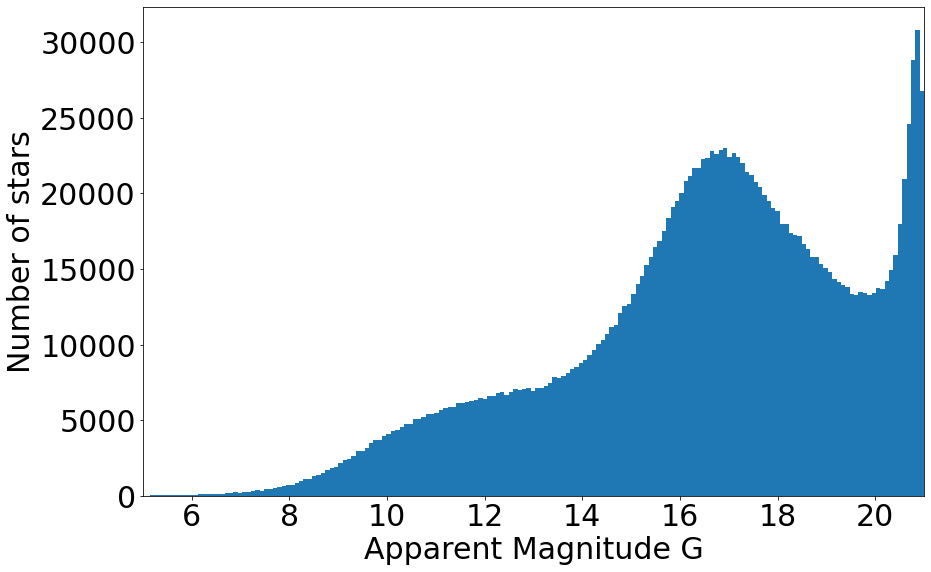

In [10]:
matplotlib.rcParams.update({'font.size': 30}) 
plt.figure(figsize=(14,9))
plt.hist(df_new['phot_g_mean_mag'], bins=200)  # arguments are passed to np.histogram
plt.xlabel('Apparent Magnitude G')
plt.ylabel('Number of stars')
plt.xlim(5,21)
plt.show()
plt.close()

In [15]:
etas = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,0.6,0.7,0.8,0.9,0.91,0.92,0.93,0.94,0.95]
tts = [30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600,625,650,675,700,725,750,775,800,825,850,875,900,925,950,975,1000]
dicte = {0:1e-4,1:5e-4,2:1e-3,3:5e-3,4:1e-2,5:5e-2,6:0.1,7:0.5,8:0.6,9:0.7,10:0.8,11:0.9,12:0.91,13:0.92,14:0.93,15:0.94,16:0.95}

##W4

In [16]:
alla =  len(df_new)
for tt in tts:
  f1 = []
  fr1 = []
  for i,ee in enumerate(etas):
    #Straight line #W4
    df_w4 = df_new[(df_new['g_abs'] < mw4[tt][i]*df_new['g_w4'] + nw4[tt][i])]
    f1.append(len(df_w4))
    fr1.append(len(df_w4)/alla)
  print('  f1_'+str(tt),' = np.array(',f1,')')
  print('  fr1_'+str(tt),' = np.array(',fr1,')')

  f1_30  = np.array( [887929, 887480, 886935, 882795, 877963, 850315, 829636, 822436, 833517, 843619, 847822, 829835, 824683, 818284, 810222, 800015, 786947] )
  fr1_30  = np.array( [0.5257343254401748, 0.5254684768057428, 0.5251457874833253, 0.5226945328139515, 0.5198335515186825, 0.5034634333788651, 0.49121959393249337, 0.4869565423335826, 0.4935174971624063, 0.4994987953918781, 0.5019873517627422, 0.4913374199419633, 0.4882869696867427, 0.4844981825782107, 0.4797247489684303, 0.4736812812364744, 0.4659438425844514] )
  f1_35  = np.array( [886456, 880402, 873161, 827027, 784507, 641779, 583072, 444111, 419708, 392455, 357680, 301477, 293006, 283690, 273171, 261203, 247038] )
  fr1_35  = np.array( [0.5248621761338977, 0.5212776602478135, 0.516990332938409, 0.48967482981838806, 0.4644991417648205, 0.37999124890241226, 0.3452313919277934, 0.26295390397831525, 0.24850511951050694, 0.23236887711812976, 0.21177892998589049, 0.17850166762289282, 0.1734860689986743, 0.1679701539020836, 0.161

##W3

In [17]:
alla = len(df_new)
for tt in tts:
  f1 = []
  fr1 = []
  for i,ee in enumerate(etas):
    #Straight line #W3
    df_w3 = df_new[(df_new['g_abs'] < mw3[tt][i]*df_new['g_w3'] + nw3[tt][i])]
    f1.append(len(df_w3))
    fr1.append(len(df_w3)/alla)
  print('  f1_'+str(tt),' = np.array(',f1,')')
  print('  fr1_'+str(tt),' = np.array(',fr1,')')

  f1_30  = np.array( [905612, 905774, 905996, 907739, 909965, 928020, 951261, 1182706, 1261355, 1353347, 1461605, 1586796, 1599888, 1612941, 1625448, 1637760, 1649526] )
  fr1_30  = np.array( [0.5362042617489998, 0.5363001804099753, 0.5364316245009417, 0.537463638242178, 0.5387816316948413, 0.54947182566961, 0.5632326009765941, 0.7002689867140812, 0.7468363124366834, 0.8013039016987669, 0.8654024350313897, 0.9395268367979509, 0.9472784856219704, 0.9550070429164957, 0.9624123187981036, 0.9697021370322411, 0.9766686738534611] )
  f1_35  = np.array( [905611, 905771, 905989, 907710, 909896, 927659, 950552, 1177548, 1253909, 1342768, 1446803, 1566501, 1579154, 1591699, 1604218, 1616381, 1628102] )
  fr1_35  = np.array( [0.5362036696585, 0.5362984041384757, 0.5364274798674428, 0.5374464676176824, 0.5387407774503518, 0.5492580809991645, 0.5628128088122013, 0.6972149839158616, 0.7424276065748098, 0.7950401763008672, 0.8566383114526289, 0.9275103601035211, 0.935002081198107, 0.9424298565187091,

##Both

In [18]:
alla = len(df_new)
for tt in tts:
  f1 = []
  fr1 = []
  for i,ee in enumerate(etas):
    #Straight line #W4
    df_w4 = df_new[(df_new['g_abs'] < mw4[tt][i]*df_new['g_w4'] + nw4[tt][i])]
    #Straight line #W3
    df_both = df_w4[(df_w4['g_abs'] < mw3[tt][i]*df_w4['g_w3'] + nw3[tt][i])]
    f1.append(len(df_both))
    fr1.append(len(df_both)/alla)
  print('  f1_'+str(tt),' = np.array(',f1,')')
  print('  fr1_'+str(tt),' = np.array(',fr1,')')

  f1_30  = np.array( [617683, 617533, 617382, 616117, 614537, 605480, 600523, 682046, 720859, 764002, 805466, 820803, 817873, 813352, 806884, 797881, 785604] )
  fr1_30  = np.array( [0.36572423621805744, 0.36563542264308013, 0.36554601697760297, 0.3647970224952944, 0.36386151950553336, 0.3584989558484035, 0.3555639632406534, 0.4038329570598207, 0.4268137656304491, 0.4523583260654224, 0.47690876655114983, 0.4859896585473296, 0.48425483338277286, 0.48157799223295683, 0.4777483508799353, 0.47241776010979725, 0.4651486650431545] )
  f1_35  = np.array( [616936, 613863, 609928, 583646, 558670, 483891, 465192, 428855, 412712, 390253, 357053, 301053, 292587, 283279, 272772, 260809, 246658] )
  fr1_35  = np.array( [0.36528194461467045, 0.36346245050863535, 0.36113257439173063, 0.34557125187470655, 0.3307831995504849, 0.2865072640622974, 0.2754357638056262, 0.2539209713126232, 0.24436285437356528, 0.23106509383746288, 0.21140768924248535, 0.17825062125095698, 0.17323798307923768, 0.1677268047066

##Both (Variable denominator)

In [20]:
alla = {0.0001:1688904,0.0005:1688802,0.001:1688655,0.005:1687516,0.01:1686074,0.05:1673190,0.1:1653775,0.5:1502374,0.6:1465000,0.7:1418438,0.8:1351374,0.9:1221731,0.91:1199857,0.92:1175137,0.93:1146296,0.94:1111697,0.95:1068918}
for tt in tts:
  f1 = []
  fr1 = []
  for i,ee in enumerate(etas):
    #Straight line #W4
    df_w4 = df_new[(df_new['g_abs'] < mw4[tt][i]*df_new['g_w4'] + nw4[tt][i])]
    #Straight line #W3
    df_both = df_w4[(df_w4['g_abs'] < mw3[tt][i]*df_w4['g_w3'] + nw3[tt][i])]
    f1.append(len(df_both))
    fr1.append(len(df_both)/alla[ee])
  print('  f1_'+str(tt),' = np.array(',f1,')')
  print('  fr1_'+str(tt),' = np.array(',fr1,')')


  f1_30  = np.array( [617683, 617533, 617382, 616117, 614537, 605480, 600523, 682046, 720859, 764002, 805466, 820803, 817873, 813352, 806884, 797881, 785604] )
  fr1_30  = np.array( [0.36573008294136317, 0.365663351890867, 0.3656057631665438, 0.36510290865390316, 0.36447807154371636, 0.3618716344228689, 0.3631225529470454, 0.45397883616196766, 0.49205392491467576, 0.5386220617326947, 0.5960348504559063, 0.6718361079484764, 0.6816420623457629, 0.6921337682329805, 0.7039054485054471, 0.7177144491709522, 0.7349525407935875] )
  f1_35  = np.array( [616936, 613863, 609928, 583646, 558670, 483891, 465192, 428855, 412712, 390253, 357053, 301053, 292587, 283279, 272772, 260809, 246658] )
  fr1_35  = np.array( [0.3652877842671934, 0.36349021377284013, 0.3611915992313409, 0.34586101702146826, 0.3313437014033785, 0.28920266078568485, 0.2812909857749694, 0.28545155866648386, 0.2817146757679181, 0.2751286979057245, 0.2642147917600901, 0.24641512738892604, 0.24385155897744482, 0.24106040402097798, 0

##Fractions checking top line


In [21]:
#Also Checking Most Massive (Brightest) Star
g_max = df_new['g_abs'].min()
l_max = df_new['lum_val'].max()
print('Min G_abs = ',g_max)
print('Max L_bol = ',l_max)
print('Mass M (From Wikipedia) = ',(l_max/1.4)**(1/3.5))

Min G_abs =  -2.4794425492556957
Max L_bol =  717.5134887695312
Mass M (From Wikipedia) =  5.945666990002973


In [23]:
etas = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,0.6,0.7,0.8,0.9,0.91,0.92,0.93,0.94,0.95]
tts = [30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600,625,650,675,700,725,750,775,800,825,850,875,900,925,950,975,1000]
g_max = df_new['g_abs'].min()
l_max = df_new['lum_val'].max()
for tt in tts:
  f1 = []
  fr1 = []
  for i,ee in enumerate(etas):
    #Straight line #W4
    df_w4 = df_new[(df_new['g_abs'] < mw4[tt][i]*df_new['g_w4'] + nw4[tt][i])]
    #Straight line #W3
    df_both = df_w4[(df_w4['g_abs'] < mw3[tt][i]*df_w4['g_w3'] + nw3[tt][i])]
    #Top line
    df_top = df_both[(df_both['g_abs'] < g_max - 2.5*np.log10(1 - ee))]
    print('Temperature = ',tt,', Eta = ',ee, ', Above region = ',len(df_top[['ra','dec']]))

Temperature =  30 , Eta =  0.0001 , Above region =  1
Temperature =  30 , Eta =  0.0005 , Above region =  1
Temperature =  30 , Eta =  0.001 , Above region =  1
Temperature =  30 , Eta =  0.005 , Above region =  1
Temperature =  30 , Eta =  0.01 , Above region =  1
Temperature =  30 , Eta =  0.05 , Above region =  2
Temperature =  30 , Eta =  0.1 , Above region =  3
Temperature =  30 , Eta =  0.5 , Above region =  17
Temperature =  30 , Eta =  0.6 , Above region =  31
Temperature =  30 , Eta =  0.7 , Above region =  57
Temperature =  30 , Eta =  0.8 , Above region =  112
Temperature =  30 , Eta =  0.9 , Above region =  146
Temperature =  30 , Eta =  0.91 , Above region =  135
Temperature =  30 , Eta =  0.92 , Above region =  124
Temperature =  30 , Eta =  0.93 , Above region =  105
Temperature =  30 , Eta =  0.94 , Above region =  87
Temperature =  30 , Eta =  0.95 , Above region =  75
Temperature =  35 , Eta =  0.0001 , Above region =  1
Temperature =  35 , Eta =  0.0005 , Above regio